<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Markov-Chain" data-toc-modified-id="Markov-Chain-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Markov Chain</a></span><ul class="toc-item"><li><span><a href="#Markov-Chain-Definition" data-toc-modified-id="Markov-Chain-Definition-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Markov Chain Definition</a></span></li><li><span><a href="#$P_{retry}$" data-toc-modified-id="$P_{retry}$-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>$P_{retry}$</a></span></li></ul></li><li><span><a href="#Monte-Carlo-Analysis" data-toc-modified-id="Monte-Carlo-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Monte Carlo Analysis</a></span><ul class="toc-item"><li><span><a href="#Simulation" data-toc-modified-id="Simulation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Simulation</a></span></li><li><span><a href="#Distance-Metric" data-toc-modified-id="Distance-Metric-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Distance Metric</a></span><ul class="toc-item"><li><span><a href="#Distance-Metric-Example" data-toc-modified-id="Distance-Metric-Example-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Distance Metric Example</a></span></li><li><span><a href="#Metastable-Failure-Timeline-Experiment" data-toc-modified-id="Metastable-Failure-Timeline-Experiment-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Metastable Failure Timeline Experiment</a></span></li></ul></li></ul></li><li><span><a href="#Metastable-Failure-Probability" data-toc-modified-id="Metastable-Failure-Probability-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metastable Failure Probability</a></span><ul class="toc-item"><li><span><a href="#Unstability" data-toc-modified-id="Unstability-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Unstability</a></span></li></ul></li><li><span><a href="#Metastable-Failure-Probability" data-toc-modified-id="Metastable-Failure-Probability-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Metastable Failure Probability</a></span></li></ul></div>

In [1]:
import numpy as np
import math
from tqdm import tqdm
from scipy.stats import poisson
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Markov Chain
### Markov Chain Definition

In [2]:
def getRates(_lambda, mu, mu_0, P, state):
    rates = []
    if (state[0] > 0 and state[1] > 0): #i,i
        rates = {
            (state[0], state[1]+1) : _lambda + mu_0 * state[0] * P,
            (state[0]+1, state[1]+1) : _lambda * P,
            (state[0]-1, state[1]+1) : mu_0 * state[0],
            (state[0], state[1]-1) : mu
        }
    elif (state[0] == 0 and state[1] > 0): #0, i
        rates = {
            (state[0], state[1]+1) : _lambda ,
            (state[0]+1, state[1]+1) : _lambda * P,
            (state[0], state[1]-1) : mu
        }
    elif (state[0] > 0 and state[1] == 0): #i, 0
        rates = {
            (state[0], state[1]+1) : _lambda + mu_0 * state[0] * P,
            (state[0]+1, state[1]+1) : _lambda * P,
            (state[0]-1, state[1]+1) : mu_0 * state[0] 
        }
    else: # 0,0
        rates = {
            (state[0], state[1]+1) : _lambda ,
            (state[0]+1, state[1]+1) : _lambda * P
        }
    
    return rates

### $P_{retry}$

In [21]:
dp_values = {}
from scipy.stats import poisson
def get_p_retry(timeout, length, mu):
    if (timeout, length , mu) in dp_values:
        return dp_values[(timeout, length, mu)]
    s = 0
    for i in range(length, -1, -1):
        if (timeout, i , mu) in dp_values:
            s += dp_values[(timeout, i, mu)]
            break;

#         p = (((mu * timeout) ** i) / math.factorial(i)) * (math.e ** (-1 * mu * timeout))
        p = poisson.pmf(k=i, mu=mu*timeout)
        dp_values[(timeout, i, mu)] = p
        s += p
#         print(f"P(N({timeout}) = {i}) = {p}")

#     print(f"P(N({timeout}) <= {length}) = {s}")
    dp_values[(timeout, length, mu)] = s
    return s

In [22]:
def plot_p_retry(timeout=1.5, max_i=50, mu=15):
    print(f'mu = {mu}, timeout = {timeout}')
    probs = []
    for i in range(max_i): 
        probs.append(get_p_retry(timeout, i, mu))
    plt.figure(figsize=(3.75,3))
    plt.plot(probs, '.-')
    plt.xticks(range(0, max_i, 4))
    plt.yticks([0,0.25, 0.5, 0.75, 1])
    plt.title(f'Retry Probabilites ($\mu$:{mu},timeout={timeout} s)', fontsize=12)
    plt.xlabel('length of primary queue', fontsize="12")
    plt.ylabel('$P_{retry}$', fontsize="14")
    plt.savefig("retry_probabilites.pdf", format="pdf", bbox_inches="tight")
    plt.show()

mu = 15, timeout = 1


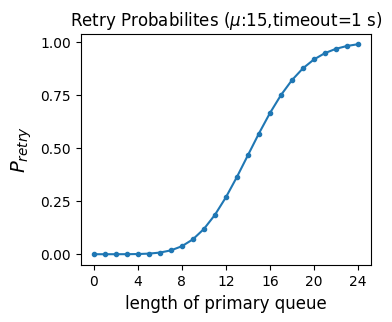

In [23]:
plot_p_retry(1,  25, 15)

In [24]:
get_p_retry(1, 20, 15)

0.9170290899685392

## Monte Carlo Analysis

### Simulation

In [25]:
def monte_carlo(x0 = (0,0), _lambda=10, mu=15, mu_0=5, timeout=1, T=1000000):
    np.random.seed(10)
    t0 = 0

    # Initialize arrays to store the simulation results
    t = []
    x = []
    x.append(x0)
    t.append(t0)

    pbar = tqdm(total=T,  position=0, leave=True)
    i = 1
    # Simulate the random walk using the Gillespie algorithm
    while (t[-1] < T):
        # Calculate the transition rates from the current state
        state = x[i-1]
        rates = getRates(_lambda, mu, mu_0, get_p_retry(timeout, state[1] , mu), state)
        values = list(rates.values())
        keys = list(rates.keys())

        # Choose the next state to transition to based on the rates
        tau = np.random.exponential(1/np.sum(values))
        pbar.update(tau)
        
        j = np.random.choice(len(keys), p=values/np.sum(values))


        # Update the state and time
        x.append(keys[j])
        t.append(t[i-1] + tau)
        i+=1
        
    # Print the simulation results
    # print("Time\tState")
    # for i in range(len(t)):
    #     print("{:.2f}\t{}".format(t[i], x[i]))
    x = np.array(x,  dtype='i,i')
    unique, counts = np.unique(x, return_counts=True)
    probabilities = counts / i
    
    return unique, probabilities



In [8]:
import matplotlib.pyplot as plt
def plot_data(unique, probabilities, _lambda, mu, mu_0, timeout, size_primary = 20, size_orbit=20):
    data = np.zeros(size_primary * size_orbit).reshape((size_orbit, size_primary))
    for i in range(0, len(unique)):
        try:
            data[unique[i][0]][unique[i][1]] = probabilities[i]
        except:
            pass
    print(f"probabilites in the plot: {np.sum(data)}")
    sns.heatmap(data, annot=True)
    plt.title(f'Markov Probabilites ($\lambda$:{_lambda}, $\mu$:{mu}, $\mu_0$={mu_0})')
#     heatmap = plt.pcolor(data)
#     plt.imshow(data, cmap='hot', interpolation='nearest')
    plt.xlabel('Queue Size')
    plt.ylabel('Orbit Size')
    plt.savefig(f"markov_probabilites.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [9]:
unique, probabilities = monte_carlo(_lambda=33, mu=40, mu_0=1, timeout=1, T=60 * 3)

 91%|█████████████████████▊  | 163.7060025532326/180 [00:00<00:00, 264.21it/s]/usr/local/lib/python3.10/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|███████████████████████| 180.01478570633512/180 [00:00<00:00, 259.94it/s]


probabilites in the plot: 0.6749418797741614


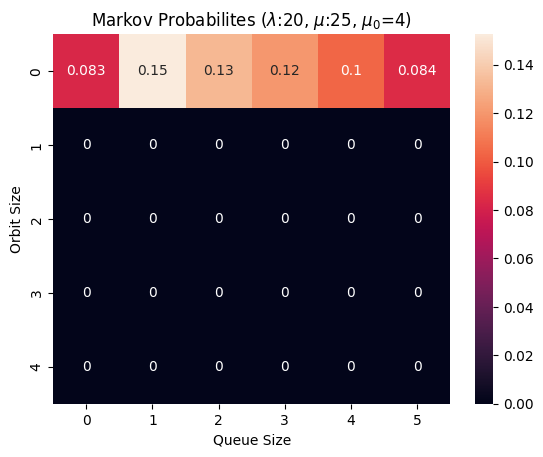

In [10]:
plot_data(unique, probabilities, _lambda=20, mu=25, mu_0=4, timeout=1, size_primary = 6, size_orbit=5)

### Distance Metric

In [11]:
def calculate_distance_metric(unique, probabilities):
    metric = 0
    for i in range(len(unique)):
        d = math.sqrt(unique[i][0] ** 2 + unique[i][1] **2) 
        metric += (d * probabilities[i])
    return metric

In [12]:
calculate_distance_metric(unique, probabilities)

4.724344071736963

#### Distance Metric Example

In [13]:
def benchmark_dm_diff_lambda(max_lambda, step, max_state_change, mu=15, timeout=0.5):
    benchmark_result = []
    lambdas = []
    mu_0 = 1 / timeout
    for _lambda in np.arange(1, max_lambda, step):
        print(f'Run monte carlo for lambda = {_lambda}')
        lambdas.append(_lambda)
        unique, probabilities = monte_carlo(_lambda=_lambda, mu=mu, mu_0=mu_0, timeout=timeout, T=max_state_change)
        benchmark_result.append(calculate_distance_metric(unique, probabilities))
    return benchmark_result

In [14]:
def plot_benchmark_result(result, max_lambda, step, mu, timeout):
    lambdas = [i for i in np.arange(1, max_lambda, step)]
    plt.figure(figsize=(6,2))
    plt.plot(lambdas, result, 'o-')
    plt.title(fr'Distance Metric ($\mu = {mu}$, $timeout={timeout}$, $\mu_0 = ' + r'\frac{1}{timeout}= ' + fr'{1/timeout}$)')
    plt.xlabel('$\lambda_{req}$', size=12)
    plt.ylabel('Distance Metric', size=12)
    plt.savefig(f"distance_metric_mu={mu}_t={timeout}_max_lambda={max_lambda}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [15]:
result = benchmark_dm_diff_lambda(10, 0.5, 60 * 100, 15, 1)

Run monte carlo for lambda = 1.0


 90%|███████████████████▊  | 5394.850757628058/6000 [00:00<00:00, 9185.88it/s]/usr/local/lib/python3.10/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████████| 6000.043429161695/6000 [00:00<00:00, 8877.39it/s]


Run monte carlo for lambda = 1.5


100%|██████████████████████| 6000.336682717185/6000 [00:01<00:00, 5649.64it/s]


Run monte carlo for lambda = 2.0


6000.5927606208425it [00:01, 4831.29it/s]                                     


Run monte carlo for lambda = 2.5


6000.795106494839it [00:01, 3813.54it/s]                                      


Run monte carlo for lambda = 3.0


100%|██████████████████████| 6000.420817613929/6000 [00:01<00:00, 3223.08it/s]


Run monte carlo for lambda = 3.5


100%|██████████████████████| 6000.094713630714/6000 [00:02<00:00, 2803.11it/s]


Run monte carlo for lambda = 4.0


100%|██████████████████████| 6000.047000204157/6000 [00:02<00:00, 2465.30it/s]


Run monte carlo for lambda = 4.5


100%|██████████████████████| 6000.141777260627/6000 [00:02<00:00, 2123.17it/s]


Run monte carlo for lambda = 5.0


100%|██████████████████████| 6000.124736825882/6000 [00:03<00:00, 1916.06it/s]


Run monte carlo for lambda = 5.5


100%|██████████████████████| 6000.099848827641/6000 [00:03<00:00, 1812.79it/s]


Run monte carlo for lambda = 6.0


100%|██████████████████████| 6000.008852940314/6000 [00:03<00:00, 1605.85it/s]


Run monte carlo for lambda = 6.5


100%|██████████████████████| 6000.001714577672/6000 [00:04<00:00, 1457.04it/s]


Run monte carlo for lambda = 7.0


100%|██████████████████████| 6000.006456957743/6000 [00:04<00:00, 1370.30it/s]


Run monte carlo for lambda = 7.5


100%|███████████████████████| 6000.004857764868/6000 [00:24<00:00, 247.24it/s]


Run monte carlo for lambda = 8.0


100%|██████████████████████| 6000.0584101462255/6000 [00:15<00:00, 389.07it/s]


Run monte carlo for lambda = 8.5


100%|███████████████████████| 6000.002729696434/6000 [00:15<00:00, 382.75it/s]


Run monte carlo for lambda = 9.0


100%|███████████████████████| 6000.054969202861/6000 [00:16<00:00, 368.81it/s]


Run monte carlo for lambda = 9.5


100%|███████████████████████| 6000.014764267579/6000 [00:20<00:00, 297.02it/s]


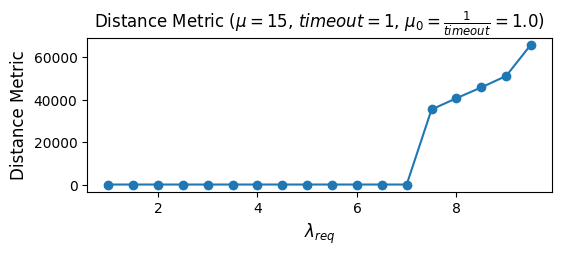

In [19]:
plot_benchmark_result(result, 10, 0.5, 15, 1)

In [17]:
def plot_benchmark_result_log_scale(result, max_lambda, step, mu, timeout):
    lambdas = [i for i in np.arange(1, 10, 0.5)]
    plt.figure(figsize=(8,3))
    plt.plot(lambdas, result, 'o-')
    plt.yscale('log')

    plt.title(fr'Distance Metric ($\mu = {mu}$, $timeout={timeout}s$, $\mu_0 = ' + r'\frac{1}{timeout}= ' + fr'{1/timeout}$)')
    plt.xlabel('$\lambda_{req}$', size=13)
    plt.ylabel('$\log_{10}($Distance Metric$)$', size=13)

    plt.savefig(f"distance_metric_logscale_mu={15}_t={1}_max_lambda={10}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

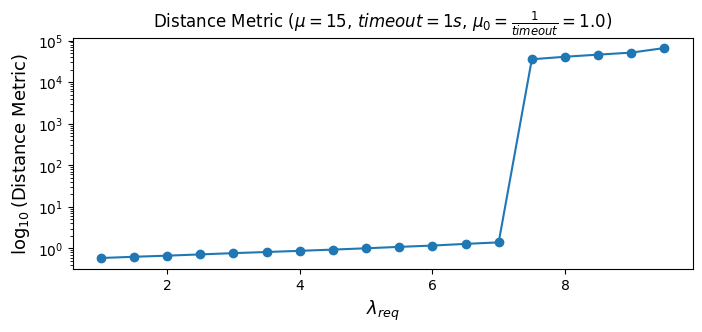

In [20]:
plot_benchmark_result_log_scale(result, 10, 0.5, 15, 1)

#### Metastable Failure Timeline Experiment

In [13]:
def timeline_simulation(mu=15, mu_0=2, timeout=0.5, _lambda=4, trigger_lambda=6, trigger=1000, T=1000000):

    # Define the initial state and time
    x0 = (0, 0)
    t0 = 0

    # Initialize arrays to store the simulation results
    t = []
    x = []
    x.append(x0)
    t.append(t0)
    
    trigger_start = random.randint(int(T/3), int(T*2/3))
    trigger_end = trigger_start + trigger
    print(f'trigger:[{trigger_start}, {trigger_end}]')

    # Simulate the random walk using the Gillespie algorithm
#     _lambda = 4
    pbar = tqdm(total=T,  position=0, leave=True)
    i = 1
    while (t[-1] < T):

        state = x[i-1]
        l = trigger_lambda if (t[-1] < trigger_end and t[-1] > trigger_start) else _lambda
        rates = getRates(l, mu, mu_0, get_p_retry(timeout, state[1] , mu), state)
        values = list(rates.values())
        keys = list(rates.keys())

        # Choose the next state to transition to based on the rates
        tau = np.random.exponential(1/np.sum(values))
        pbar.update(tau)
        
        j = np.random.choice(len(keys), p=values/np.sum(values))

        # Update the state and time
        x.append(keys[j])
        t.append(t[i-1] + tau)
        i+=1

    # Print the simulation results
    # print("Time\tState")
    # for i in range(len(t)):
    #     print("{:.2f}\t{}".format(t[i], x[i]))
    x = np.array(x,  dtype='i,i')
    unique, counts = np.unique(x, return_counts=True)
    probabilities = counts / i
    
    return unique, probabilities, x, np.array(t), trigger_start, trigger_end

In [22]:
unique, probabilities, x, t, start, end = timeline_simulation(mu=15, mu_0=1, timeout=1, _lambda=4, trigger_lambda=5, trigger=100000, T=1000000)

trigger:[651801, 751801]


100%|████████████████████▉| 999751.96114169/1000000 [07:03<00:00, 2603.16it/s]/usr/local/lib/python3.10/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████| 1000000.0258397614/1000000 [07:15<00:00, 2293.94it/s]


In [15]:
def plot_ms_timeline(mu, mu_0, l, lp, unique, probabilities, x, t, start, end):
    b = []
    time_quantum = 1000
    for i in tqdm(range(time_quantum, int(t[-1]), time_quantum), desc="Epoch...", position=0, leave=True):
        o = x[(t > i) & (t < i + time_quantum)]
        u, c = np.unique(o, return_counts=True)
        p = c / len(o)
        b.append(calculate_distance_metric(u, p))
    plt.plot(b)
    plt.title(fr'Distance Metric Timeline ($\mu={mu}$, $\mu_0={mu_0}$, $timeout={1/mu_0}s$)')
    plt.xlabel('Time', size="13")
    plt.ylabel('Distance Metric', size="13")
    plt.axvline(x = start/time_quantum, color = 'r', linestyle="dotted")
    plt.axvline(x = end/time_quantum, color = 'r', linestyle="dotted")
    plt.text(start/time_quantum - 55, 0.95,'Trigger Started',rotation=90, color='b', size="13")
    plt.text(end/time_quantum + 15, 0.95,'Trigger ended',rotation=90, color='b', size="13")
    plt.savefig(f"timeline_{l}->{lp}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

Epoch...: 100%|█████████████████████████████| 999/999 [00:21<00:00, 46.68it/s]


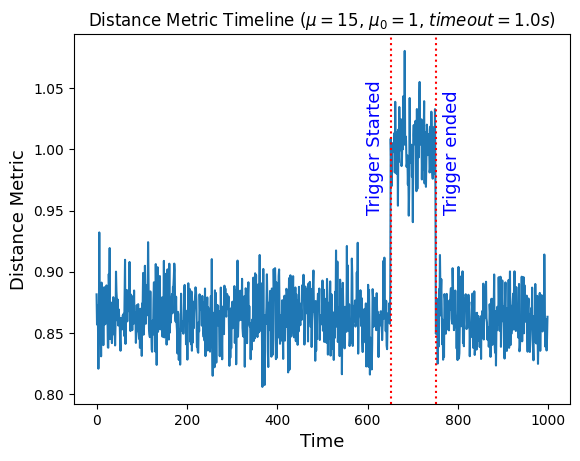

In [31]:
plot_ms_timeline(15, 1, 4, 5, unique, probabilities, x, t, start, end)

In [28]:
unique, probabilities, x, t, start, end = timeline_simulation(mu=15, mu_0=1, timeout=1, _lambda=4, trigger_lambda=6, trigger=100000, T=1000000)

trigger:[439777, 539777]


100%|███████████████████| 1000000.0368731782/1000000 [21:39<00:00, 769.42it/s]


Epoch...: 100%|█████████████████████████████| 999/999 [01:18<00:00, 12.76it/s]


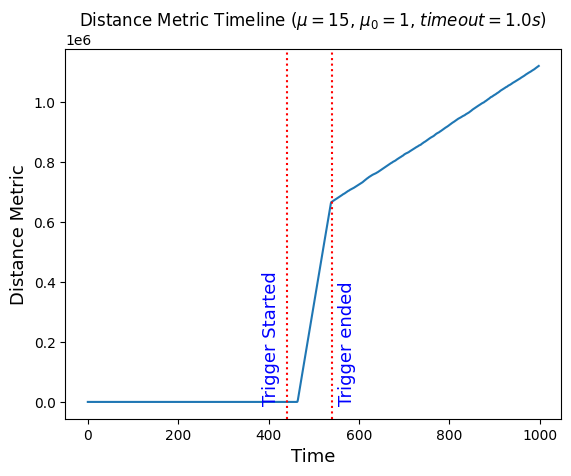

In [29]:
plot_ms_timeline(15, 1, 4, 6, unique, probabilities, x, t, start, end)

## Metastable Failure Probability


### Unstability
We should define unstability for the system based on distance metric.: 
$$
\text{Distance Metric} > \alpha
$$
Based on previous observation in simulation we can choose this alpha as a number larger than a not too large number. 


In [30]:
def is_unstable(unique, probabilities, alpha=50):
    distance = calculate_distance_metric(unique, probabilities) 
    print(f'distance is {distance}')
    return distance > alpha

starting from (0,0)

In [31]:
unique, probabilities = monte_carlo(_lambda=5, mu=15, mu_0=1, timeout=1, T=36000)
is_unstable(unique, probabilities)

100%|█████████████████████| 36000.18866602213/36000 [00:19<00:00, 1894.48it/s]

distance is 0.9984185768332966


False

starting from (5, 5)

starting from (20, 20)

In [32]:
unique, probabilities = monte_carlo(x0=(20,20), _lambda=5, mu=15, mu_0=1, timeout=1, T=36000)
is_unstable(unique, probabilities)

100%|██████████████████████| 36000.06102898669/36000 [01:08<00:00, 525.57it/s]


distance is 90002.07821750766


True

In [33]:
u = [ [0]*20 for i in range(20)]
d = [ [0]*20 for i in range(20)]
for i in np.arange(1, 20, 1): 
    j = 0
    for l in np.arange(10/20, 10 + 10/20, 10/20):
        print(i, l)
        unique, probabilities = monte_carlo(x0=(0,0), _lambda=l, mu=i, mu_0=1, timeout=1, T=60 * 60)
        d[i][j] = calculate_distance_metric(unique, probabilities) 
#         u[i][j] = is_unstable(unique, probabilities)
        j += 1

1 0.5


3600.876450598943it [00:04, 856.87it/s]                                       


1 1.0


100%|██████████████████████| 3600.003990148174/3600 [00:01<00:00, 1806.73it/s]


1 1.5


100%|█████████████████████| 3600.0441655002846/3600 [00:02<00:00, 1501.03it/s]


1 2.0


100%|██████████████████████| 3600.306987751067/3600 [00:02<00:00, 1287.58it/s]


1 2.5


100%|█████████████████████| 3600.1322975046655/3600 [00:03<00:00, 1163.88it/s]


1 3.0


100%|██████████████████████| 3600.0058279810914/3600 [00:03<00:00, 998.51it/s]


1 3.5


100%|██████████████████████| 3600.0366568281797/3600 [00:03<00:00, 927.89it/s]


1 4.0


100%|███████████████████████| 3600.074505766832/3600 [00:04<00:00, 818.67it/s]


1 4.5


100%|██████████████████████| 3600.1608905531357/3600 [00:04<00:00, 741.75it/s]


1 5.0


100%|██████████████████████| 3600.0209500214073/3600 [00:05<00:00, 689.71it/s]


1 5.5


100%|██████████████████████| 3600.0305416995147/3600 [00:05<00:00, 634.36it/s]


1 6.0


100%|██████████████████████| 3600.0494905974447/3600 [00:05<00:00, 615.14it/s]


1 6.5


100%|███████████████████████| 3600.039197453855/3600 [00:06<00:00, 572.41it/s]


1 7.0


100%|██████████████████████| 3600.0129231744927/3600 [00:06<00:00, 549.84it/s]


1 7.5


100%|██████████████████████| 3600.0294662940414/3600 [00:06<00:00, 519.45it/s]


1 8.0


100%|██████████████████████| 3600.0692874100137/3600 [00:07<00:00, 482.43it/s]


1 8.5


100%|██████████████████████| 3600.0137884734067/3600 [00:07<00:00, 461.33it/s]


1 9.0


100%|███████████████████████| 3600.006599286464/3600 [00:08<00:00, 438.84it/s]


1 9.5


100%|███████████████████████| 3600.018444575199/3600 [00:08<00:00, 423.47it/s]


1 10.0


100%|███████████████████████| 3600.003310749707/3600 [00:08<00:00, 403.31it/s]


2 0.5


100%|█████████████████████| 3600.1455234859345/3600 [00:00<00:00, 4722.06it/s]


2 1.0


100%|██████████████████████| 3600.403953894462/3600 [00:02<00:00, 1697.07it/s]


2 1.5


100%|█████████████████████| 3600.0348501827584/3600 [00:02<00:00, 1427.01it/s]


2 2.0


100%|█████████████████████| 3600.0051719375006/3600 [00:02<00:00, 1219.03it/s]


2 2.5


100%|█████████████████████| 3600.0424791214778/3600 [00:03<00:00, 1081.78it/s]


2 3.0


3600.5581744126243it [00:03, 973.36it/s]                                      


2 3.5


100%|██████████████████████| 3600.0221997262493/3600 [00:04<00:00, 878.49it/s]


2 4.0


100%|██████████████████████| 3600.0121425998423/3600 [00:04<00:00, 803.42it/s]


2 4.5


100%|███████████████████████| 3600.073111373135/3600 [00:04<00:00, 754.48it/s]


2 5.0


100%|██████████████████████| 3600.0006876929483/3600 [00:05<00:00, 677.31it/s]


2 5.5


100%|███████████████████████| 3600.103944021782/3600 [00:05<00:00, 647.47it/s]


2 6.0


100%|███████████████████████| 3600.017483579789/3600 [00:05<00:00, 605.64it/s]


2 6.5


100%|██████████████████████| 3600.0189067432784/3600 [00:06<00:00, 538.11it/s]


2 7.0


100%|██████████████████████| 3600.0434076730926/3600 [00:06<00:00, 533.21it/s]


2 7.5


100%|███████████████████████| 3600.040822614243/3600 [00:07<00:00, 505.77it/s]


2 8.0


100%|███████████████████████| 3600.009666146438/3600 [00:07<00:00, 474.02it/s]


2 8.5


100%|██████████████████████| 3600.1489769687223/3600 [00:08<00:00, 442.92it/s]


2 9.0


100%|███████████████████████| 3600.026011791744/3600 [00:08<00:00, 426.04it/s]


2 9.5


100%|██████████████████████| 3600.0790738529736/3600 [00:08<00:00, 418.75it/s]


2 10.0


100%|███████████████████████| 3600.028856025633/3600 [00:09<00:00, 397.55it/s]


3 0.5


3603.1429099467423it [00:00, 14818.47it/s]                                    


3 1.0


3600.8966011383995it [00:01, 1842.55it/s]                                     


3 1.5


100%|█████████████████████| 3600.0392763605387/3600 [00:02<00:00, 1281.19it/s]


3 2.0


100%|█████████████████████| 3600.0586110233253/3600 [00:03<00:00, 1113.09it/s]


3 2.5


100%|██████████████████████| 3600.010100136915/3600 [00:03<00:00, 1030.13it/s]


3 3.0


100%|██████████████████████| 3600.0046584083784/3600 [00:03<00:00, 920.30it/s]


3 3.5


100%|██████████████████████| 3600.1974252981795/3600 [00:04<00:00, 839.24it/s]


3 4.0


100%|██████████████████████| 3600.2456458931574/3600 [00:04<00:00, 772.93it/s]


3 4.5


100%|██████████████████████| 3600.0876301696517/3600 [00:04<00:00, 721.30it/s]


3 5.0


100%|███████████████████████| 3600.067618554163/3600 [00:05<00:00, 663.41it/s]


3 5.5


100%|███████████████████████| 3600.006812265351/3600 [00:05<00:00, 638.58it/s]


3 6.0


100%|███████████████████████| 3600.018848686509/3600 [00:06<00:00, 572.66it/s]


3 6.5


100%|██████████████████████| 3600.0864647725607/3600 [00:06<00:00, 544.72it/s]


3 7.0


100%|██████████████████████| 3600.0483319363543/3600 [00:06<00:00, 522.26it/s]


3 7.5


100%|████████████████████████| 3600.00589245962/3600 [00:07<00:00, 490.76it/s]


3 8.0


100%|██████████████████████| 3600.0188095396093/3600 [00:07<00:00, 459.32it/s]


3 8.5


100%|███████████████████████| 3600.084674472341/3600 [00:08<00:00, 438.10it/s]


3 9.0


100%|███████████████████████| 3600.005148496261/3600 [00:08<00:00, 420.69it/s]


3 9.5


100%|██████████████████████| 3600.0106155004423/3600 [00:08<00:00, 410.08it/s]


3 10.0


100%|███████████████████████| 3600.008479104301/3600 [00:09<00:00, 382.51it/s]


4 0.5


3602.040678896714it [00:00, 16652.91it/s]                                     


4 1.0


100%|█████████████████████| 3600.2214362330333/3600 [00:01<00:00, 2375.62it/s]


4 1.5


100%|█████████████████████| 3600.0108211945526/3600 [00:03<00:00, 1060.59it/s]


4 2.0


100%|█████████████████████| 3600.0655075099257/3600 [00:03<00:00, 1086.58it/s]


4 2.5


100%|██████████████████████| 3600.001512318773/3600 [00:03<00:00, 1002.87it/s]


4 3.0


100%|███████████████████████| 3600.096069505461/3600 [00:04<00:00, 887.15it/s]


4 3.5


100%|███████████████████████| 3600.002347662055/3600 [00:04<00:00, 819.02it/s]


4 4.0


100%|██████████████████████| 3600.0086921041584/3600 [00:04<00:00, 759.80it/s]


4 4.5


100%|███████████████████████| 3600.042257566181/3600 [00:05<00:00, 705.10it/s]


4 5.0


100%|██████████████████████| 3600.0563195389323/3600 [00:05<00:00, 668.79it/s]


4 5.5


100%|██████████████████████| 3600.0076132845957/3600 [00:05<00:00, 616.65it/s]


4 6.0


100%|███████████████████████| 3600.014787270002/3600 [00:06<00:00, 576.30it/s]


4 6.5


100%|██████████████████████| 3600.0363248365575/3600 [00:06<00:00, 542.81it/s]


4 7.0


100%|██████████████████████| 3600.0048259156856/3600 [00:07<00:00, 513.44it/s]


4 7.5


100%|███████████████████████| 3600.028358828039/3600 [00:07<00:00, 489.34it/s]


4 8.0


100%|██████████████████████| 3600.0476146854853/3600 [00:07<00:00, 463.05it/s]


4 8.5


100%|██████████████████████| 3600.0227443110603/3600 [00:08<00:00, 443.71it/s]


4 9.0


100%|███████████████████████| 3600.062552062515/3600 [00:08<00:00, 426.78it/s]


4 9.5


100%|████████████████████████| 3600.01135416083/3600 [00:08<00:00, 410.85it/s]


4 10.0


100%|██████████████████████| 3600.0325468337937/3600 [00:09<00:00, 389.39it/s]


5 0.5


100%|████████████████████| 3600.4591752738793/3600 [00:00<00:00, 15781.94it/s]


5 1.0


100%|█████████████████████| 3600.4577393197947/3600 [00:00<00:00, 8283.56it/s]


5 1.5


100%|█████████████████████| 3600.1758061347937/3600 [00:02<00:00, 1412.91it/s]


5 2.0


100%|█████████████████████| 3600.1387931196173/3600 [00:03<00:00, 1055.02it/s]


5 2.5


100%|██████████████████████| 3600.0178063699323/3600 [00:03<00:00, 948.11it/s]


5 3.0


100%|███████████████████████| 3600.039174749174/3600 [00:04<00:00, 871.40it/s]


5 3.5


100%|██████████████████████| 3600.0050702120857/3600 [00:04<00:00, 791.55it/s]


5 4.0


100%|██████████████████████| 3600.1106688711284/3600 [00:04<00:00, 737.70it/s]


5 4.5


100%|███████████████████████| 3600.020429517863/3600 [00:05<00:00, 690.71it/s]


5 5.0


100%|███████████████████████| 3600.083441933509/3600 [00:05<00:00, 643.61it/s]


5 5.5


100%|██████████████████████| 3600.1101439683753/3600 [00:06<00:00, 593.29it/s]


5 6.0


100%|███████████████████████| 3600.004761223898/3600 [00:06<00:00, 562.68it/s]


5 6.5


100%|██████████████████████| 3600.0222828673914/3600 [00:06<00:00, 534.41it/s]


5 7.0


100%|██████████████████████| 3600.0216562388673/3600 [00:07<00:00, 496.12it/s]


5 7.5


100%|██████████████████████| 3600.0019916660976/3600 [00:07<00:00, 478.41it/s]


5 8.0


100%|██████████████████████| 3600.0437827402498/3600 [00:07<00:00, 453.30it/s]


5 8.5


100%|███████████████████████| 3600.010108593981/3600 [00:08<00:00, 428.60it/s]


5 9.0


100%|██████████████████████| 3600.0583206914876/3600 [00:08<00:00, 419.75it/s]


5 9.5


100%|███████████████████████| 3600.010531079276/3600 [00:09<00:00, 392.77it/s]


5 10.0


100%|███████████████████████| 3600.010079786086/3600 [00:09<00:00, 381.38it/s]


6 0.5


3601.99548147446it [00:00, 18863.47it/s]                                      


6 1.0


3601.9241542960517it [00:00, 9112.52it/s]                                     


6 1.5


100%|█████████████████████| 3600.0650394367854/3600 [00:00<00:00, 5490.46it/s]


6 2.0


100%|██████████████████████| 3600.1687615505934/3600 [00:03<00:00, 968.19it/s]


6 2.5


100%|███████████████████████| 3600.110589896453/3600 [00:03<00:00, 923.57it/s]


6 3.0


100%|███████████████████████| 3600.086752820435/3600 [00:04<00:00, 825.26it/s]


6 3.5


100%|███████████████████████| 3600.035029410123/3600 [00:04<00:00, 767.99it/s]


6 4.0


100%|███████████████████████| 3600.049634930111/3600 [00:05<00:00, 714.49it/s]


6 4.5


100%|███████████████████████| 3600.080317952097/3600 [00:05<00:00, 668.46it/s]


6 5.0


100%|██████████████████████| 3600.1111171572416/3600 [00:05<00:00, 615.42it/s]


6 5.5


100%|███████████████████████| 3600.017311050186/3600 [00:06<00:00, 577.61it/s]


6 6.0


100%|██████████████████████| 3600.0151464058986/3600 [00:06<00:00, 550.60it/s]


6 6.5


100%|██████████████████████| 3600.1011785008513/3600 [00:06<00:00, 524.11it/s]


6 7.0


100%|███████████████████████| 3600.048730985695/3600 [00:07<00:00, 493.99it/s]


6 7.5


100%|███████████████████████| 3600.015575267305/3600 [00:07<00:00, 469.18it/s]


6 8.0


100%|███████████████████████| 3600.018788915587/3600 [00:07<00:00, 453.68it/s]


6 8.5


100%|███████████████████████| 3600.054055398363/3600 [00:08<00:00, 429.69it/s]


6 9.0


100%|██████████████████████| 3600.0674776552546/3600 [00:08<00:00, 413.53it/s]


6 9.5


100%|███████████████████████| 3600.001979314861/3600 [00:09<00:00, 395.74it/s]


6 10.0


100%|██████████████████████| 3600.0170291621807/3600 [00:09<00:00, 379.91it/s]


7 0.5


3602.3037085073383it [00:00, 19401.73it/s]                                    


7 1.0


100%|██████████████████████| 3600.347919301967/3600 [00:00<00:00, 9747.27it/s]


7 1.5


100%|██████████████████████| 3600.290817853193/3600 [00:00<00:00, 6424.91it/s]


7 2.0


100%|█████████████████████| 3600.1081586625787/3600 [00:03<00:00, 1077.38it/s]


7 2.5


100%|████████████████████████| 3600.13559304018/3600 [00:04<00:00, 896.82it/s]


7 3.0


100%|███████████████████████| 3600.017484095517/3600 [00:04<00:00, 801.45it/s]


7 3.5


100%|███████████████████████| 3600.043068110232/3600 [00:04<00:00, 756.53it/s]


7 4.0


100%|███████████████████████| 3600.001912341182/3600 [00:05<00:00, 705.79it/s]


7 4.5


100%|███████████████████████| 3600.206426717943/3600 [00:05<00:00, 651.01it/s]


7 5.0


100%|███████████████████████| 3600.064312098617/3600 [00:05<00:00, 610.44it/s]


7 5.5


100%|██████████████████████| 3600.0062102076663/3600 [00:06<00:00, 571.10it/s]


7 6.0


 92%|████████████████████▏ | 3301.0885150899207/3600 [00:05<00:00, 387.79it/s]

In [34]:
np.arange(10/20, 10 + 10/20, 10/20)

In [35]:
# sns.set(font_scale=1)
ax = sns.heatmap(d[1:])
ax.set(xlabel="System Load ($\lambda$)", ylabel="Processing Rate ($\mu$)", 
      title="Distance Metric ($\mu_0=1$, $timeout=1$)")
ax.set_yticks(list(np.arange(1, 20, 2) -0.5))
ax.set_yticklabels(list(np.arange(1, 20, 2)))
ax.set_xticks(list(np.arange(2, 21, 2) -0.5))
ax.set_xticklabels(list(range(1, 11)))
plt.savefig("distance_metric_lambda_mu.pdf", format="pdf", bbox_inches="tight")

## Metastable Failure Probability


In [3]:
def calculate_boundry_states(l, mu, mu_0, timeout):
    stationary_states = {}
    i = 0
    iBoundry = False
    while (not iBoundry):
        j = 0
        jBoundry = False
        while (not jBoundry):
            print(f"calculating for {i}, {j}")
            unique, probabilities = monte_carlo(x0=(i,j), _lambda=l, mu=mu, mu_0=mu_0, timeout=timeout, T=60 * 3)
            if is_unstable(unique, probabilities):
                jBoundry = True
                if j == 0:
                    iBoundry = True
            else:
                stationary_states[(i, j)] = calculate_distance_metric(unique, probabilities)
                
            j += 1
        i+=1
        
    return stationary_states
    

<Axes: >

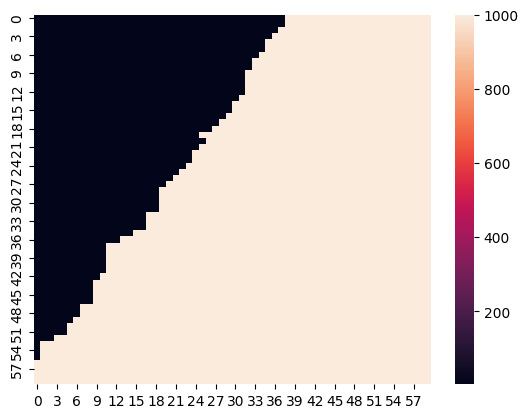

In [19]:
x = [[1000 for i in range(60)] for i in range(60)]
for i in range(60):
    for j in range(60):
        if (i, j) in s:
            x[i][j] = s[(i, j)]

sns.heatmap(x)

In [234]:
def meta_prob(l, lp, mu, mu_0, timeout, s=None):
    
    
        
    stationary_states = {}
    
    if (s): 
        stationary_states = s
    else: 
        stationary_states = calculate_boundry_states(l, mu, mu_0, timeout)
   
    
    stationary_states = set(stationary_states.keys())
    unique, probabilities = monte_carlo(x0=(0,0), _lambda=lp, mu=mu, mu_0=mu_0, timeout=timeout, T=60 )
    
    
    
    prob = 0
    if is_unstable(unique, probabilities, alpha=500):
        return 1
    else:
        for i in range(len(unique)):
            if (unique[i][0], unique[i][1]) not in stationary_states:
                prob += probabilities[i]
    return prob

In [4]:
trigger_values = list(np.arange(31, 37, 0.1))
j = []
for i in trigger_values:
    j.append(meta_prob(30, i, 40, 1, 1, s))

In [6]:
experiment_values = [1000/32, 1000/31, 1000/30, 1000/29, 1000/28, 1000/27]
experiment_ms = [0,0,0,0,1,1]

In [7]:
def plot_validation(queueing_ms, trigger_values, experiment_values, experiment_ms, mu, l, mu_0, timeout):
    plt.figure(figsize=(6,3))
    plt.plot(trigger_values, queueing_ms,  '.-')
    plt.plot(experiment_values, experiment_ms, 'o-')
    plt.title(f'Queuing Model Validation ($\mu={mu}$, $\lambda={l}$, $\mu_0={mu_0}$, $timeout={timeout}s$)')
    plt.xlabel('Trigger Rate ($\lambda\'$)', size=12)
    plt.ylabel('Metastable Failure Occurrence', size=12)
    plt.legend(["Queuing Model Simulation", "Prototype Experiment"], loc ="upper left")
    plt.savefig(f"queueing_validation_{mu}_{l}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


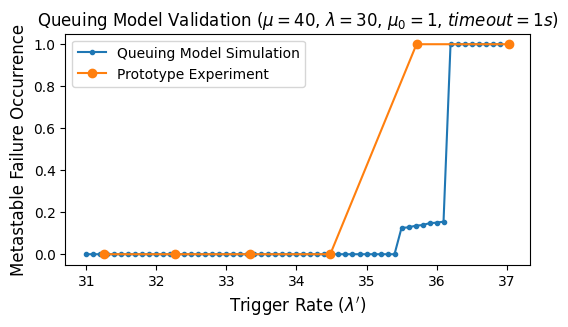

In [8]:
plot_validation(j, trigger_values, experiment_values, experiment_ms, 40, 30, 1, 1)

In [164]:
s2 = calculate_boundry_states(15, 27, 1, 1)
s2

calculating for 0, 0


 87%|█████████████████████████████████████████████████████████████████████████████▋           | 157.2167187781548/180 [00:00<00:00, 398.99it/s]/usr/local/lib/python3.10/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0028594993837/180 [00:00<00:00, 366.24it/s]


distance is 1.8768584922161968
calculating for 0, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03294695207347/180 [00:00<00:00, 573.94it/s]


distance is 1.9186535764375876
calculating for 0, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00940174042833/180 [00:00<00:00, 577.95it/s]


distance is 1.8788249694002448
calculating for 0, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02195534736327/180 [00:00<00:00, 555.44it/s]


distance is 1.9213109008061686
calculating for 0, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03588697750266/180 [00:00<00:00, 520.46it/s]


distance is 1.882599580712788
calculating for 0, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02160791732683/180 [00:00<00:00, 461.93it/s]


distance is 1.925718290119131
calculating for 0, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01687322080255/180 [00:00<00:00, 551.99it/s]


distance is 1.8875109170305677
calculating for 0, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00031713676668/180 [00:00<00:00, 579.65it/s]


distance is 1.9311613242249084
calculating for 0, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00410973107847/180 [00:00<00:00, 549.00it/s]


distance is 1.8937358227185481
calculating for 0, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05827736701295/180 [00:00<00:00, 531.04it/s]


distance is 1.9385288966725043
calculating for 0, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05748172357502/180 [00:00<00:00, 452.77it/s]


distance is 1.9016050244242848
calculating for 0, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04320607177115/180 [00:00<00:00, 546.06it/s]


distance is 1.946935201401051
calculating for 0, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03881486349857/180 [00:00<00:00, 516.18it/s]


distance is 1.9131193300767622
calculating for 0, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03775028780578/180 [00:00<00:00, 507.61it/s]


distance is 1.9595446584938703
calculating for 0, 14


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0223038136709/180 [00:00<00:00, 517.58it/s]


distance is 1.926029309141661
calculating for 0, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02302856876162/180 [00:00<00:00, 543.41it/s]


distance is 1.9733846962003152
calculating for 0, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.14246355797266/180 [00:00<00:00, 473.18it/s]


distance is 1.939996511425083
calculating for 0, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01461390856358/180 [00:00<00:00, 501.06it/s]


distance is 1.9910745537276868
calculating for 0, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10297801801886/180 [00:00<00:00, 566.64it/s]


distance is 1.9577882435025296
calculating for 0, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00788979478833/180 [00:00<00:00, 541.44it/s]


distance is 2.009275463773189
calculating for 0, 20


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.032475209021/180 [00:00<00:00, 572.84it/s]


distance is 1.976277690563405
calculating for 0, 21


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00852977775398/180 [00:00<00:00, 543.44it/s]


distance is 2.0431582473350147
calculating for 0, 22


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03139548186985/180 [00:00<00:00, 544.29it/s]


distance is 2.0149274715249237
calculating for 0, 23


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07830101910213/180 [00:00<00:00, 529.43it/s]


distance is 2.067337958014992
calculating for 0, 24


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08178470599083/180 [00:00<00:00, 498.83it/s]


distance is 2.0397581683420527
calculating for 0, 25


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05488391531628/180 [00:00<00:00, 496.70it/s]


distance is 2.093146552676567
calculating for 0, 26


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01323091855008/180 [00:00<00:00, 523.92it/s]


distance is 2.067224806193882
calculating for 0, 27


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.33520269262397/180 [00:00<00:00, 502.77it/s]


distance is 2.1493685181766082
calculating for 0, 28


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01758298316028/180 [00:00<00:00, 483.24it/s]


distance is 2.1726264167335874
calculating for 0, 29


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07486732839993/180 [00:00<00:00, 564.02it/s]


distance is 2.251207547062923
calculating for 0, 30


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2630300669049/180 [00:00<00:00, 537.19it/s]


distance is 2.2373617205892224
calculating for 0, 31


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.00018390120775/180 [00:02<00:00, 85.48it/s]


distance is 2840.0572684748977
calculating for 1, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00533815828757/180 [00:00<00:00, 553.90it/s]


distance is 1.8828275556619583
calculating for 1, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0279348217176/180 [00:00<00:00, 547.89it/s]


distance is 1.92191370242807
calculating for 1, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04736203965655/180 [00:00<00:00, 466.85it/s]


distance is 1.8839905804664199
calculating for 1, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00316296821967/180 [00:00<00:00, 486.67it/s]


distance is 1.924199598679722
calculating for 1, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07206393126495/180 [00:00<00:00, 271.71it/s]


distance is 1.8869191436746537
calculating for 1, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03993573853182/180 [00:00<00:00, 232.91it/s]


distance is 1.9282141217390354
calculating for 1, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03081981842956/180 [00:00<00:00, 273.21it/s]


distance is 1.8918441162817525
calculating for 1, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04320761978303/180 [00:00<00:00, 335.59it/s]


distance is 1.9331981551406257
calculating for 1, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.16007422640223/180 [00:00<00:00, 411.15it/s]


distance is 1.8977108480585392
calculating for 1, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0344972318118/180 [00:00<00:00, 478.54it/s]


distance is 1.9405503798694077
calculating for 1, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.14305546410168/180 [00:00<00:00, 433.90it/s]


distance is 1.9054330932705912
calculating for 1, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02069324496372/180 [00:00<00:00, 524.93it/s]


distance is 1.9486761385288376
calculating for 1, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00539448694315/180 [00:00<00:00, 362.62it/s]


distance is 1.9150275017302105
calculating for 1, 13


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0063738398648/180 [00:00<00:00, 248.58it/s]


distance is 1.9622464766724237
calculating for 1, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.12621965283796/180 [00:00<00:00, 370.94it/s]


distance is 1.9288389710298541
calculating for 1, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00507610527237/180 [00:00<00:00, 344.10it/s]


distance is 1.97966398158503
calculating for 1, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08824196922933/180 [00:00<00:00, 468.38it/s]


distance is 1.946552757506122
calculating for 1, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00042553964678/180 [00:00<00:00, 397.94it/s]


distance is 1.997801365705569
calculating for 1, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02042968453253/180 [00:00<00:00, 439.96it/s]


distance is 1.9649940788826863
calculating for 1, 19


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0045315194208/180 [00:00<00:00, 511.40it/s]


distance is 2.016475709378171
calculating for 1, 20


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05745942764014/180 [00:00<00:00, 343.29it/s]


distance is 1.9869457676313085
calculating for 1, 21


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00382384815688/180 [00:00<00:00, 447.89it/s]


distance is 2.039511626382789
calculating for 1, 22


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01227734619195/180 [00:00<00:00, 216.41it/s]


distance is 2.0109799294217123
calculating for 1, 23


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01120952449432/180 [00:00<00:00, 509.00it/s]


distance is 2.0634149317092096
calculating for 1, 24


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01182263296843/180 [00:00<00:00, 427.76it/s]


distance is 2.035710815916952
calculating for 1, 25


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0561016117834/180 [00:00<00:00, 506.21it/s]


distance is 2.0881949132852964
calculating for 1, 26


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00775121336187/180 [00:00<00:00, 521.22it/s]


distance is 2.0903068167084426
calculating for 1, 27


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0348592641663/180 [00:00<00:00, 484.56it/s]


distance is 2.14581867968766
calculating for 1, 28


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01432150488964/180 [00:00<00:00, 533.30it/s]


distance is 2.1921802950804565
calculating for 1, 29


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02363355273374/180 [00:00<00:00, 524.63it/s]


distance is 2.282294379540659
calculating for 1, 30


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00731751057165/180 [00:00<00:00, 201.15it/s]


distance is 2838.8660686286566
calculating for 2, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0584369934615/180 [00:00<00:00, 549.00it/s]


distance is 1.8975467138480469
calculating for 2, 1


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.002045978513/180 [00:00<00:00, 568.41it/s]


distance is 1.9251792915976431
calculating for 2, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.13444004549453/180 [00:00<00:00, 501.70it/s]


distance is 1.8985103649345687
calculating for 2, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00824086797905/180 [00:00<00:00, 569.36it/s]


distance is 1.926661763379803
calculating for 2, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03898611679347/180 [00:00<00:00, 519.62it/s]


distance is 1.9017385887587719
calculating for 2, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02234592776665/180 [00:00<00:00, 542.75it/s]


distance is 1.9304482503247522
calculating for 2, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00105034212496/180 [00:00<00:00, 517.39it/s]


distance is 1.906197404425311
calculating for 2, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0307675022369/180 [00:00<00:00, 560.67it/s]


distance is 1.935028288470976
calculating for 2, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00354843353568/180 [00:00<00:00, 504.91it/s]


distance is 1.9124492809755842
calculating for 2, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0227553435674/180 [00:00<00:00, 543.73it/s]


distance is 1.9418537160154854
calculating for 2, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03806667398172/180 [00:00<00:00, 524.45it/s]


distance is 1.9197326123510812
calculating for 2, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00024570036683/180 [00:00<00:00, 565.60it/s]


distance is 1.9555635245797665
calculating for 2, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09468350996985/180 [00:00<00:00, 478.75it/s]


distance is 1.9189374700080377
calculating for 2, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02801486199337/180 [00:00<00:00, 571.86it/s]


distance is 1.967109077229309
calculating for 2, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05786237623917/180 [00:00<00:00, 527.31it/s]


distance is 1.932392386558389
calculating for 2, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0392653343334/180 [00:00<00:00, 508.06it/s]


distance is 1.9831176496708118
calculating for 2, 16


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0229886646636/180 [00:00<00:00, 523.09it/s]


distance is 1.9495099882275606
calculating for 2, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03484641104095/180 [00:00<00:00, 557.59it/s]


distance is 2.000748359077372
calculating for 2, 18


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0781533850323/180 [00:00<00:00, 466.34it/s]


distance is 1.9675424453288555
calculating for 2, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00214299349946/180 [00:00<00:00, 562.24it/s]


distance is 2.019189288605372
calculating for 2, 20


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04316522408558/180 [00:00<00:00, 516.57it/s]


distance is 1.9910713249578424
calculating for 2, 21


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0911492738403/180 [00:00<00:00, 541.34it/s]


distance is 2.0429905478715713
calculating for 2, 22


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00538455577075/180 [00:00<00:00, 590.61it/s]


distance is 2.0157808708453424
calculating for 2, 23


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0440066740453/180 [00:00<00:00, 507.99it/s]


distance is 2.0679817242751457
calculating for 2, 24


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04732877237473/180 [00:00<00:00, 560.49it/s]


distance is 2.0403648744521603
calculating for 2, 25


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03222439679246/180 [00:00<00:00, 534.85it/s]


distance is 2.109637463730669
calculating for 2, 26


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00589859212818/180 [00:00<00:00, 555.35it/s]


distance is 2.099147410068034
calculating for 2, 27


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.3213350204009/180 [00:00<00:00, 528.90it/s]


distance is 2.149539449650094
calculating for 2, 28


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0222622141832/180 [00:00<00:00, 521.05it/s]


distance is 2.295878557313325
calculating for 2, 29


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00259587002404/180 [00:00<00:00, 206.33it/s]


distance is 2845.7661923296896
calculating for 3, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00121032473115/180 [00:00<00:00, 528.11it/s]


distance is 1.9054447393676566
calculating for 3, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0056339949716/180 [00:00<00:00, 553.79it/s]


distance is 1.9285816533224527
calculating for 3, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08371955025578/180 [00:00<00:00, 536.70it/s]


distance is 1.9061002163331797
calculating for 3, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03950241026155/180 [00:00<00:00, 573.50it/s]


distance is 1.929514321845296
calculating for 3, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00889243187186/180 [00:00<00:00, 501.46it/s]


distance is 1.908628010405771
calculating for 3, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0074448813063/180 [00:00<00:00, 557.19it/s]


distance is 1.9329313551538132
calculating for 3, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0780496767351/180 [00:00<00:00, 525.97it/s]


distance is 1.912812846082451
calculating for 3, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02038631844735/180 [00:00<00:00, 573.21it/s]


distance is 1.9370791067081043
calculating for 3, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0220143227038/180 [00:00<00:00, 514.36it/s]


distance is 1.918452037602103
calculating for 3, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00181147704072/180 [00:00<00:00, 556.68it/s]


distance is 1.9496908563769049
calculating for 3, 10


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0075565450501/180 [00:00<00:00, 524.83it/s]


distance is 1.925231108262534
calculating for 3, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02044137947772/180 [00:00<00:00, 510.88it/s]


distance is 1.9610849429316561
calculating for 3, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0011160949906/180 [00:00<00:00, 514.89it/s]


distance is 1.933112437367255
calculating for 3, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05175851807476/180 [00:00<00:00, 527.12it/s]


distance is 1.9720865478883451
calculating for 3, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06107043339915/180 [00:00<00:00, 375.45it/s]


distance is 1.9450138437167006
calculating for 3, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00446654490847/180 [00:00<00:00, 462.48it/s]


distance is 1.9874828262141702
calculating for 3, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02890159346887/180 [00:00<00:00, 376.11it/s]


distance is 1.9612010034218033
calculating for 3, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00025016804577/180 [00:00<00:00, 363.27it/s]


distance is 2.004368638358216
calculating for 3, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00829117873542/180 [00:00<00:00, 511.73it/s]


distance is 1.9785553196920207
calculating for 3, 19


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0683323602929/180 [00:00<00:00, 545.29it/s]


distance is 2.0217499809602546
calculating for 3, 20


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0180571094219/180 [00:00<00:00, 494.48it/s]


distance is 1.9997666559535219
calculating for 3, 21


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0125336951729/180 [00:00<00:00, 459.97it/s]


distance is 2.0491833622795275
calculating for 3, 22


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.054738789204/180 [00:00<00:00, 534.60it/s]


distance is 2.0234024805477033
calculating for 3, 23


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.44477616291164/180 [00:00<00:00, 568.00it/s]


distance is 2.073021952297324
calculating for 3, 24


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0068021063804/180 [00:00<00:00, 339.15it/s]


distance is 2.0631180567265295
calculating for 3, 25


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06689552486586/180 [00:00<00:00, 532.25it/s]


distance is 2.1170978269740264
calculating for 3, 26


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05305023487438/180 [00:00<00:00, 508.82it/s]


distance is 2.0908042506374476
calculating for 3, 27


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.294635062812/180 [00:00<00:00, 509.75it/s]


distance is 2.150666864725634
calculating for 3, 28


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00797525607283/180 [00:00<00:00, 197.03it/s]


distance is 2841.8100224488844
calculating for 4, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.13043198148569/180 [00:00<00:00, 560.44it/s]


distance is 1.908683779938852
calculating for 4, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08266277474303/180 [00:00<00:00, 525.85it/s]


distance is 1.9372896233417294
calculating for 4, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05768597858736/180 [00:00<00:00, 504.21it/s]


distance is 1.9094720630267894
calculating for 4, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0309296067402/180 [00:00<00:00, 521.33it/s]


distance is 1.938608808832188
calculating for 4, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09350290829968/180 [00:00<00:00, 556.96it/s]


distance is 1.9117849850437583
calculating for 4, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00121953703456/180 [00:00<00:00, 518.13it/s]


distance is 1.941573651384396
calculating for 4, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0610361120782/180 [00:00<00:00, 494.28it/s]


distance is 1.9153252485834198
calculating for 4, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00540976270665/180 [00:00<00:00, 572.80it/s]


distance is 1.9456813703267621
calculating for 4, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00190725173763/180 [00:00<00:00, 532.45it/s]


distance is 1.925979110568949
calculating for 4, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02159293734329/180 [00:00<00:00, 529.72it/s]


distance is 1.9560836349166484
calculating for 4, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07134538543826/180 [00:00<00:00, 498.76it/s]


distance is 1.9321094756012354
calculating for 4, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04157255540753/180 [00:00<00:00, 573.57it/s]


distance is 1.9678612222532585
calculating for 4, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06738212087905/180 [00:00<00:00, 496.64it/s]


distance is 1.937586419615649
calculating for 4, 13


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0196968792449/180 [00:00<00:00, 384.84it/s]


distance is 1.9780811632458088
calculating for 4, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03605308608832/180 [00:00<00:00, 504.53it/s]


distance is 1.949260138751153
calculating for 4, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09261083459882/180 [00:00<00:00, 568.24it/s]


distance is 1.9914850211611559
calculating for 4, 16


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0336886835445/180 [00:00<00:00, 509.44it/s]


distance is 1.965599594993128
calculating for 4, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08857313651055/180 [00:00<00:00, 492.75it/s]


distance is 2.00751050422631
calculating for 4, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00331266561625/180 [00:00<00:00, 527.20it/s]


distance is 1.9818669444187509
calculating for 4, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04340507746804/180 [00:00<00:00, 553.77it/s]


distance is 2.0250156075182106
calculating for 4, 20


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07271470201587/180 [00:00<00:00, 523.12it/s]


distance is 2.002496093214098
calculating for 4, 21


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0132461996134/180 [00:00<00:00, 563.31it/s]


distance is 2.051451358510562
calculating for 4, 22


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01045942133618/180 [00:00<00:00, 532.27it/s]


distance is 2.044036224383763
calculating for 4, 23


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.42684488401494/180 [00:00<00:00, 569.85it/s]


distance is 2.0941149190823625
calculating for 4, 24


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0660557894262/180 [00:00<00:00, 534.80it/s]


distance is 2.072206938368334
calculating for 4, 25


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.39626660308522/180 [00:00<00:00, 563.93it/s]


distance is 2.121411919171616
calculating for 4, 26


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00015337780675/180 [00:00<00:00, 535.85it/s]


distance is 2.1006691822585153
calculating for 4, 27


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00005936454053/180 [00:00<00:00, 206.62it/s]


distance is 2837.865939700108
calculating for 5, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07153577498443/180 [00:00<00:00, 574.82it/s]


distance is 1.9181260399668436
calculating for 5, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06504162102783/180 [00:00<00:00, 554.81it/s]


distance is 1.940152233962015
calculating for 5, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0038974701492/180 [00:00<00:00, 590.99it/s]


distance is 1.9187777853658137
calculating for 5, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01694078174978/180 [00:00<00:00, 587.02it/s]


distance is 1.9412670601961313
calculating for 5, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04545027936626/180 [00:00<00:00, 543.47it/s]


distance is 1.9207629917258762
calculating for 5, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0026148815636/180 [00:00<00:00, 591.25it/s]


distance is 1.943871299195623
calculating for 5, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0152630554432/180 [00:00<00:00, 541.96it/s]


distance is 1.9239208713196296
calculating for 5, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01914843570168/180 [00:00<00:00, 577.69it/s]


distance is 1.947247352323255
calculating for 5, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0763911195158/180 [00:00<00:00, 534.63it/s]


distance is 1.9275376290356423
calculating for 5, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01323843083898/180 [00:00<00:00, 581.56it/s]


distance is 1.957649000950411
calculating for 5, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06299079703155/180 [00:00<00:00, 546.61it/s]


distance is 1.9335267434820063
calculating for 5, 11


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.033217770468/180 [00:00<00:00, 570.90it/s]


distance is 1.969160971791107
calculating for 5, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05902690040583/180 [00:00<00:00, 526.78it/s]


distance is 1.9387750430841166
calculating for 5, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01134076297754/180 [00:00<00:00, 544.19it/s]


distance is 1.979182279064703
calculating for 5, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02769525353682/180 [00:00<00:00, 509.92it/s]


distance is 1.9502777799858195
calculating for 5, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08424993148378/180 [00:00<00:00, 591.28it/s]


distance is 1.9924362910772768
calculating for 5, 16


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0253226444397/180 [00:00<00:00, 530.43it/s]


distance is 1.9664868085542044
calculating for 5, 17


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.4406042426238/180 [00:00<00:00, 572.77it/s]


distance is 2.0234802282222315
calculating for 5, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01003907253542/180 [00:00<00:00, 517.74it/s]


distance is 1.9968727110237734
calculating for 5, 19


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.4043174139124/180 [00:00<00:00, 568.11it/s]


distance is 2.0452784711987735
calculating for 5, 20


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0320432282694/180 [00:00<00:00, 544.06it/s]


distance is 2.02185791039434
calculating for 5, 21


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.42344774928688/180 [00:00<00:00, 589.73it/s]


distance is 2.071248848568552
calculating for 5, 22


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00016607444653/180 [00:00<00:00, 537.10it/s]


distance is 2.0461895939097663
calculating for 5, 23


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.402013131182/180 [00:00<00:00, 579.46it/s]


distance is 2.0961387069133006
calculating for 5, 24


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0411724177721/180 [00:00<00:00, 544.58it/s]


distance is 2.0740984550072072
calculating for 5, 25


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.37132912541784/180 [00:00<00:00, 588.64it/s]


distance is 2.1232018332521023
calculating for 5, 26


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0155781450039/180 [00:00<00:00, 212.21it/s]


distance is 2841.9999524387454
calculating for 6, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04392065149102/180 [00:00<00:00, 544.54it/s]


distance is 1.9220947709224048
calculating for 6, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0288443810444/180 [00:00<00:00, 553.86it/s]


distance is 1.9424229953855983
calculating for 6, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0004774940895/180 [00:00<00:00, 547.58it/s]


distance is 1.9225011102329717
calculating for 6, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01323102112372/180 [00:00<00:00, 314.52it/s]


distance is 1.943578450773337
calculating for 6, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0099348695337/180 [00:00<00:00, 547.19it/s]


distance is 1.9228579156601615
calculating for 6, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01382063598257/180 [00:00<00:00, 575.27it/s]


distance is 1.9456902433920038
calculating for 6, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07106452319297/180 [00:00<00:00, 519.02it/s]


distance is 1.925587659646806
calculating for 6, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00791520428695/180 [00:00<00:00, 562.68it/s]


distance is 1.9553636409566832
calculating for 6, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05767613104192/180 [00:00<00:00, 501.85it/s]


distance is 1.9309849649525495
calculating for 6, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02792298579715/180 [00:00<00:00, 580.36it/s]


distance is 1.9663896596852637
calculating for 6, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05377459044448/180 [00:00<00:00, 548.69it/s]


distance is 1.9358339331017986
calculating for 6, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00617234755438/180 [00:00<00:00, 527.30it/s]


distance is 1.9760786006022548
calculating for 6, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02268064116078/180 [00:00<00:00, 526.17it/s]


distance is 1.9470578380760266
calculating for 6, 13


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0794977996116/180 [00:00<00:00, 513.14it/s]


distance is 1.9890971839183171
calculating for 6, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02098831669835/180 [00:00<00:00, 554.31it/s]


distance is 1.9630653615499378
calculating for 6, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.4368907785513/180 [00:00<00:00, 502.16it/s]


distance is 2.0199717627719953
calculating for 6, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00718682388853/180 [00:00<00:00, 589.91it/s]


distance is 1.993304068733151
calculating for 6, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.40257884476722/180 [00:00<00:00, 541.06it/s]


distance is 2.0416370362449596
calculating for 6, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00771856923876/180 [00:00<00:00, 594.37it/s]


distance is 2.016066963432945
calculating for 6, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.39159777653578/180 [00:00<00:00, 526.53it/s]


distance is 2.0651159685289713
calculating for 6, 20


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03695393758832/180 [00:00<00:00, 568.00it/s]


distance is 2.042674747201051
calculating for 6, 21


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.37366021715246/180 [00:00<00:00, 570.83it/s]


distance is 2.091206749293755
calculating for 6, 22


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00480519046863/180 [00:00<00:00, 581.81it/s]


distance is 2.070263230329482
calculating for 6, 23


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.27895495189944/180 [00:00<00:00, 539.70it/s]


distance is 2.119585998644389
calculating for 6, 24


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07484630151438/180 [00:00<00:00, 556.72it/s]


distance is 2.1079518341523147
calculating for 6, 25


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08464271395198/180 [00:00<00:00, 543.80it/s]


distance is 2.281794430101007
calculating for 6, 26


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0347928805224/180 [00:00<00:00, 220.73it/s]


distance is 2826.3318113043524
calculating for 7, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09780717340837/180 [00:00<00:00, 550.64it/s]


distance is 1.9290214810519155
calculating for 7, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00524552109397/180 [00:00<00:00, 590.82it/s]


distance is 1.9518271610769031
calculating for 7, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03882757547723/180 [00:00<00:00, 545.22it/s]


distance is 1.929501703408805
calculating for 7, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0108805981159/180 [00:00<00:00, 600.67it/s]


distance is 1.9521682900410553
calculating for 7, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0444337486812/180 [00:00<00:00, 564.05it/s]


distance is 1.9265411188807129
calculating for 7, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00590704377723/180 [00:00<00:00, 591.49it/s]


distance is 1.953975011902509
calculating for 7, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06154379487603/180 [00:00<00:00, 559.23it/s]


distance is 1.9288212917230558
calculating for 7, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02926491044053/180 [00:00<00:00, 577.96it/s]


distance is 1.9635073647330104
calculating for 7, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01079627455172/180 [00:00<00:00, 581.93it/s]


distance is 1.9366378323334374
calculating for 7, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03603808183533/180 [00:00<00:00, 552.06it/s]


distance is 1.979934127653446
calculating for 7, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01876387061918/180 [00:00<00:00, 549.38it/s]


distance is 1.9433082901505463
calculating for 7, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00218950420017/180 [00:00<00:00, 538.34it/s]


distance is 1.9883698279412716
calculating for 7, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02691019592385/180 [00:00<00:00, 585.80it/s]


distance is 1.953669718029215
calculating for 7, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00202501260188/180 [00:00<00:00, 546.13it/s]


distance is 2.0009723721972863
calculating for 7, 14


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0097952313305/180 [00:00<00:00, 574.46it/s]


distance is 1.9692854434025102
calculating for 7, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0248800347833/180 [00:00<00:00, 518.13it/s]


distance is 2.015417767679037
calculating for 7, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07570475926198/180 [00:00<00:00, 570.51it/s]


distance is 1.984282201309428
calculating for 7, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.43547998678883/180 [00:00<00:00, 449.89it/s]


distance is 2.03168658193311
calculating for 7, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00463699321898/180 [00:00<00:00, 600.08it/s]


distance is 2.0052766381653324
calculating for 7, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.39847087285784/180 [00:00<00:00, 595.55it/s]


distance is 2.053884770427168
calculating for 7, 20


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00159835035151/180 [00:00<00:00, 515.15it/s]


distance is 2.0284715298840603
calculating for 7, 21


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2801050766791/180 [00:00<00:00, 583.92it/s]


distance is 2.109809720020695
calculating for 7, 22


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07119159645063/180 [00:00<00:00, 518.90it/s]


distance is 2.0886525319979774
calculating for 7, 23


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.19364373847355/180 [00:00<00:00, 249.43it/s]


distance is 2.1406944140122075
calculating for 7, 24


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02969557413493/180 [00:00<00:00, 503.66it/s]


distance is 2.1836739150732547
calculating for 7, 25


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.013376060056/180 [00:00<00:00, 215.23it/s]


distance is 2820.9810276016924
calculating for 8, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0771560570545/180 [00:00<00:00, 599.86it/s]


distance is 1.9321457330442269
calculating for 8, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00843010816433/180 [00:00<00:00, 560.17it/s]


distance is 1.960560795160759
calculating for 8, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02186909480892/180 [00:00<00:00, 593.30it/s]


distance is 1.9325693876809071
calculating for 8, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00795815736117/180 [00:00<00:00, 543.52it/s]


distance is 1.9607962368580791
calculating for 8, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00628898462367/180 [00:00<00:00, 515.88it/s]


distance is 1.9332256619602268
calculating for 8, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0271653049415/180 [00:00<00:00, 541.80it/s]


distance is 1.962704381741756
calculating for 8, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01417103040006/180 [00:00<00:00, 597.54it/s]


distance is 1.9351121831447187
calculating for 8, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0370535587586/180 [00:00<00:00, 548.32it/s]


distance is 1.9777283854335541
calculating for 8, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02258341915012/180 [00:00<00:00, 590.16it/s]


distance is 1.9418630370682513
calculating for 8, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0088327826613/180 [00:00<00:00, 536.57it/s]


distance is 1.9940318815382865
calculating for 8, 10


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0111799441183/180 [00:00<00:00, 565.06it/s]


distance is 1.9485278756288567
calculating for 8, 11


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0120878444064/180 [00:00<00:00, 539.19it/s]


distance is 1.9943311933996772
calculating for 8, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0288576661809/180 [00:00<00:00, 563.77it/s]


distance is 1.9617370761652035
calculating for 8, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00973041668394/180 [00:00<00:00, 545.52it/s]


distance is 2.007425971122864
calculating for 8, 14


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0610622701937/180 [00:00<00:00, 577.73it/s]


distance is 1.9756892846126315
calculating for 8, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.42161860418412/180 [00:00<00:00, 557.02it/s]


distance is 2.022547854388804
calculating for 8, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00639899143934/180 [00:00<00:00, 578.23it/s]


distance is 1.9957314243783268
calculating for 8, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.38728981331855/180 [00:00<00:00, 557.06it/s]


distance is 2.0439421155353035
calculating for 8, 18


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0074468375439/180 [00:00<00:00, 579.04it/s]


distance is 2.018592472192556
calculating for 8, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.37627410516825/180 [00:00<00:00, 504.43it/s]


distance is 2.067197902467616
calculating for 8, 20


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02160625403695/180 [00:00<00:00, 586.21it/s]


distance is 2.0446516641182813
calculating for 8, 21


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.35828642598335/180 [00:00<00:00, 541.28it/s]


distance is 2.093102682552411
calculating for 8, 22


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00007953148406/180 [00:00<00:00, 571.56it/s]


distance is 2.115247805746578
calculating for 8, 23


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.16139245013755/180 [00:00<00:00, 552.07it/s]


distance is 2.1858159821281045
calculating for 8, 24


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02081114873448/180 [00:00<00:00, 593.39it/s]


distance is 2.3968154483216635
calculating for 8, 25


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0161613138127/180 [00:00<00:00, 214.57it/s]


distance is 2841.001041328986
calculating for 9, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03843353022663/180 [00:00<00:00, 608.48it/s]


distance is 1.9383880935892648
calculating for 9, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06201661982982/180 [00:00<00:00, 545.57it/s]


distance is 1.9753755287899306
calculating for 9, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0366621887429/180 [00:00<00:00, 595.70it/s]


distance is 1.9387775189444478
calculating for 9, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0250764325043/180 [00:00<00:00, 554.16it/s]


distance is 1.9760450966257863
calculating for 9, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0825533538965/180 [00:00<00:00, 592.28it/s]


distance is 1.935657225608444
calculating for 9, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03488641616826/180 [00:00<00:00, 554.70it/s]


distance is 1.9774061561665752
calculating for 9, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02553061470985/180 [00:00<00:00, 589.41it/s]


distance is 1.9408732184154727
calculating for 9, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0095703951615/180 [00:00<00:00, 544.78it/s]


distance is 1.9924037239482106
calculating for 9, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01028779468515/180 [00:00<00:00, 579.14it/s]


distance is 1.9513286626446351
calculating for 9, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.44998551732715/180 [00:00<00:00, 548.81it/s]


distance is 1.9910858849590547
calculating for 9, 10


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.015993956349/180 [00:00<00:00, 599.07it/s]


distance is 1.9576018918068343
calculating for 9, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.44777015819363/180 [00:00<00:00, 554.16it/s]


distance is 2.0021806230059127
calculating for 9, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04847104494294/180 [00:00<00:00, 585.04it/s]


distance is 1.9698517556005788
calculating for 9, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.40933799290127/180 [00:00<00:00, 520.06it/s]


distance is 2.016026917347031
calculating for 9, 14


100%|███████████████████████████████████████████████████████████████████████████████████████████| 180.01820348093/180 [00:00<00:00, 591.54it/s]


distance is 1.9888426797486056
calculating for 9, 15


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.376301698951/180 [00:00<00:00, 547.46it/s]


distance is 2.0363727871394905
calculating for 9, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01019064227654/180 [00:00<00:00, 590.96it/s]


distance is 2.0108089326160226
calculating for 9, 17


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.3679672001407/180 [00:00<00:00, 554.98it/s]


distance is 2.0588573924201587
calculating for 9, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01528801791613/180 [00:00<00:00, 582.96it/s]


distance is 2.036035289210622
calculating for 9, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.35438007114732/180 [00:00<00:00, 552.63it/s]


distance is 2.084180235833972
calculating for 9, 20


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0003357971533/180 [00:00<00:00, 571.78it/s]


distance is 2.063111936371867
calculating for 9, 21


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2653747148891/180 [00:00<00:00, 558.42it/s]


distance is 2.1119520377707404
calculating for 9, 22


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2658896241916/180 [00:00<00:00, 550.63it/s]


distance is 2.1516931513922883
calculating for 9, 23


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06466241236492/180 [00:00<00:00, 463.08it/s]


distance is 2.280734585942126
calculating for 9, 24


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09852184857365/180 [00:00<00:00, 550.16it/s]


distance is 2.862783425136423
calculating for 9, 25


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0045276590849/180 [00:00<00:00, 206.42it/s]


distance is 2841.7697337677787
calculating for 10, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02533960895045/180 [00:00<00:00, 556.07it/s]


distance is 1.9409964327421383
calculating for 10, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0574397513492/180 [00:00<00:00, 574.03it/s]


distance is 1.9767577900373738
calculating for 10, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0266050199084/180 [00:00<00:00, 542.61it/s]


distance is 1.94134896060328
calculating for 10, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02217677067887/180 [00:00<00:00, 580.00it/s]


distance is 1.9775387725391342
calculating for 10, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07965369205925/180 [00:00<00:00, 530.48it/s]


distance is 1.9370978359511342
calculating for 10, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03198675427575/180 [00:00<00:00, 584.71it/s]


distance is 1.978794236176497
calculating for 10, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02263095259536/180 [00:00<00:00, 532.64it/s]


distance is 1.9421968446572289
calculating for 10, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00667073226728/180 [00:00<00:00, 576.42it/s]


distance is 1.9936680155971893
calculating for 10, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0073881293545/180 [00:00<00:00, 555.41it/s]


distance is 1.9525266050366812
calculating for 10, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.4470858451436/180 [00:00<00:00, 578.70it/s]


distance is 1.99222626485329
calculating for 10, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01309426664918/180 [00:00<00:00, 532.59it/s]


distance is 1.9586811398881905
calculating for 10, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.44487042751257/180 [00:00<00:00, 589.56it/s]


distance is 2.003207887089792
calculating for 10, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04557122606428/180 [00:00<00:00, 551.01it/s]


distance is 1.970824520961574
calculating for 10, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.40643799898032/180 [00:00<00:00, 589.64it/s]


distance is 2.016954393891705
calculating for 10, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01530316678213/180 [00:00<00:00, 516.35it/s]


distance is 1.9897224375413993
calculating for 10, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.37340084706892/180 [00:00<00:00, 580.46it/s]


distance is 2.0372138781973006
calculating for 10, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00728896952455/180 [00:00<00:00, 531.93it/s]


distance is 2.011608540000176
calculating for 10, 17


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.365064409676/180 [00:00<00:00, 585.15it/s]


distance is 2.0596241888803397
calculating for 10, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00004830442546/180 [00:00<00:00, 547.76it/s]


distance is 2.0572059662318014
calculating for 10, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.25958254592507/180 [00:00<00:00, 510.91it/s]


distance is 2.1059474023504308
calculating for 10, 20


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01301065302238/180 [00:00<00:00, 546.19it/s]


distance is 2.099650285425736
calculating for 10, 21


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08833575797226/180 [00:00<00:00, 376.95it/s]


distance is 2.2095364647905806
calculating for 10, 22


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0569616024026/180 [00:00<00:00, 474.74it/s]


distance is 2.2200165084023
calculating for 10, 23


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01065191394167/180 [00:00<00:00, 557.79it/s]


distance is 2.302878716132087
calculating for 10, 24


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00261080831768/180 [00:00<00:00, 196.22it/s]


distance is 2828.5209822936727
calculating for 11, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00604715610362/180 [00:00<00:00, 529.95it/s]


distance is 1.952351954560237
calculating for 11, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05266259440782/180 [00:00<00:00, 546.24it/s]


distance is 1.9783164511112934
calculating for 11, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05375846069418/180 [00:00<00:00, 535.07it/s]


distance is 1.9520003578053022
calculating for 11, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0130234693715/180 [00:00<00:00, 580.15it/s]


distance is 1.980595252463588
calculating for 11, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04980977382274/180 [00:00<00:00, 532.07it/s]


distance is 1.9431974066654825
calculating for 11, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0251555118549/180 [00:00<00:00, 578.39it/s]


distance is 1.9816998920240363
calculating for 11, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01579971002803/180 [00:00<00:00, 539.41it/s]


distance is 1.944987695475923
calculating for 11, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00290300892814/180 [00:00<00:00, 565.43it/s]


distance is 1.9959992220179361
calculating for 11, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00055688448572/180 [00:00<00:00, 538.96it/s]


distance is 1.9550743072605
calculating for 11, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.4402545950581/180 [00:00<00:00, 578.37it/s]


distance is 1.994656444417731
calculating for 11, 10


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0062630025063/180 [00:00<00:00, 532.44it/s]


distance is 1.9609832238450144
calculating for 11, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.43803912863427/180 [00:00<00:00, 578.08it/s]


distance is 2.0053994538701687
calculating for 11, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0387398481154/180 [00:00<00:00, 523.66it/s]


distance is 1.9728990337328387
calculating for 11, 13


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.3996064548117/180 [00:00<00:00, 538.29it/s]


distance is 2.0189308434328557
calculating for 11, 14


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.008471299967/180 [00:00<00:00, 520.36it/s]


distance is 1.9915953453517004
calculating for 11, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.36656840382676/180 [00:00<00:00, 576.94it/s]


distance is 2.0390024356639276
calculating for 11, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01853590689652/180 [00:00<00:00, 514.69it/s]


distance is 2.0460835559893558
calculating for 11, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.30008591869438/180 [00:00<00:00, 562.12it/s]


distance is 2.0865733029730014
calculating for 11, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01248232947904/180 [00:00<00:00, 432.10it/s]


distance is 2.07131080511727
calculating for 11, 19


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.214062633046/180 [00:00<00:00, 539.74it/s]


distance is 2.1143744831210336
calculating for 11, 20


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0318970692501/180 [00:00<00:00, 538.78it/s]


distance is 2.1158506802877457
calculating for 11, 21


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02468569941666/180 [00:00<00:00, 386.17it/s]


distance is 2.2421003873962384
calculating for 11, 22


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02174021226156/180 [00:00<00:00, 480.56it/s]


distance is 2.224310720487804
calculating for 11, 23


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00371147640598/180 [00:00<00:00, 197.87it/s]


distance is 2829.703207245767
calculating for 12, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05916749598134/180 [00:00<00:00, 428.43it/s]


distance is 1.9574714621005032
calculating for 12, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0417950656534/180 [00:00<00:00, 472.65it/s]


distance is 1.981426954974214
calculating for 12, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01555980967467/180 [00:00<00:00, 495.58it/s]


distance is 1.9577579941688712
calculating for 12, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0207914211189/180 [00:00<00:00, 426.27it/s]


distance is 1.9955167998708847
calculating for 12, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01636579038527/180 [00:00<00:00, 510.27it/s]


distance is 1.9542420000800185
calculating for 12, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00105480779698/180 [00:00<00:00, 485.30it/s]


distance is 1.9964883819756094
calculating for 12, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00349874159144/180 [00:00<00:00, 472.57it/s]


distance is 1.954989771759085
calculating for 12, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.44112208268365/180 [00:00<00:00, 503.90it/s]


distance is 1.9940043901841458
calculating for 12, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00508934603735/180 [00:00<00:00, 532.19it/s]


distance is 1.9599119131414995
calculating for 12, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.42764159811975/180 [00:00<00:00, 485.50it/s]


distance is 2.00349442907509
calculating for 12, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02838979337733/180 [00:00<00:00, 521.02it/s]


distance is 1.9702547245700262
calculating for 12, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.38935183045663/180 [00:00<00:00, 466.68it/s]


distance is 2.0156146639990857
calculating for 12, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01342735202354/180 [00:00<00:00, 518.63it/s]


distance is 1.98805604799217
calculating for 12, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.35680417327296/180 [00:00<00:00, 421.44it/s]


distance is 2.0345856411081744
calculating for 12, 14


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0076334395953/180 [00:00<00:00, 541.88it/s]


distance is 2.00880179229945
calculating for 12, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.3497586222714/180 [00:00<00:00, 500.89it/s]


distance is 2.0559845052910988
calculating for 12, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02503529676846/180 [00:00<00:00, 502.26it/s]


distance is 2.033061813000389
calculating for 12, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.33882438438349/180 [00:00<00:00, 508.83it/s]


distance is 2.080444304593337
calculating for 12, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01183253512355/180 [00:00<00:00, 537.85it/s]


distance is 2.05847830249386
calculating for 12, 19


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0822124267432/180 [00:00<00:00, 474.06it/s]


distance is 2.2082679455654666
calculating for 12, 20


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0145423822492/180 [00:00<00:00, 523.92it/s]


distance is 2.386097037384045
calculating for 12, 21


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0059956275675/180 [00:00<00:00, 443.96it/s]


distance is 2.4749471531228506
calculating for 12, 22


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0063240245131/180 [00:00<00:00, 205.80it/s]


distance is 2832.8810124860815
calculating for 13, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03445279734282/180 [00:00<00:00, 597.49it/s]


distance is 1.978869430321578
calculating for 13, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01789653414346/180 [00:00<00:00, 577.52it/s]


distance is 1.996742197263125
calculating for 13, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00765800354674/180 [00:00<00:00, 571.48it/s]


distance is 1.9791376782928343
calculating for 13, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0204659432243/180 [00:00<00:00, 559.63it/s]


distance is 1.9935599556650303
calculating for 13, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0052314946051/180 [00:00<00:00, 241.40it/s]


distance is 1.9595975302317294
calculating for 13, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.43922126538013/180 [00:00<00:00, 242.64it/s]


distance is 1.9947701215093483
calculating for 13, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0076853129474/180 [00:01<00:00, 106.27it/s]


distance is 1.9601549055347443
calculating for 13, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.4282857850866/180 [00:00<00:00, 200.04it/s]


distance is 2.0032155455939624
calculating for 13, 8


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.017956566119/180 [00:01<00:00, 160.89it/s]


distance is 1.9835419495644542
calculating for 13, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.36951846147826/180 [00:01<00:00, 175.69it/s]


distance is 2.0179669910640077
calculating for 13, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00493605768608/180 [00:00<00:00, 472.65it/s]


distance is 1.9936996703253085
calculating for 13, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.33391446972934/180 [00:00<00:00, 512.42it/s]


distance is 2.029164034451939
calculating for 13, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06798503173695/180 [00:00<00:00, 435.92it/s]


distance is 2.0089226118693944
calculating for 13, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.30396230543886/180 [00:00<00:00, 447.80it/s]


distance is 2.0467139523965057
calculating for 13, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03592390301696/180 [00:00<00:00, 507.43it/s]


distance is 2.027805128513931
calculating for 13, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.29742251045138/180 [00:00<00:00, 396.94it/s]


distance is 2.0669082044852365
calculating for 13, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01170953343075/180 [00:01<00:00, 163.45it/s]


distance is 2.057214216152646
calculating for 13, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.25454124678998/180 [00:00<00:00, 269.26it/s]


distance is 2.1061875005755315
calculating for 13, 18


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.086871385799/180 [00:00<00:00, 364.18it/s]


distance is 2.1515174496610805
calculating for 13, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03253508914682/180 [00:00<00:00, 427.33it/s]


distance is 2.217450695879687
calculating for 13, 20


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0095247061477/180 [00:01<00:00, 144.42it/s]


distance is 2824.333171105527
calculating for 14, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01122823917584/180 [00:00<00:00, 492.51it/s]


distance is 1.984558302118476
calculating for 14, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01892827332793/180 [00:00<00:00, 542.42it/s]


distance is 1.9943272296494954
calculating for 14, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0036938304188/180 [00:00<00:00, 530.39it/s]


distance is 1.960177230687396
calculating for 14, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.43768362733272/180 [00:00<00:00, 562.31it/s]


distance is 1.9951686785109572
calculating for 14, 4


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.006147777068/180 [00:00<00:00, 561.25it/s]


distance is 1.9603763930842997
calculating for 14, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.42674859724724/180 [00:00<00:00, 566.29it/s]


distance is 2.003269026985224
calculating for 14, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01642042782936/180 [00:00<00:00, 519.25it/s]


distance is 1.9834363375738333
calculating for 14, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.36798515940092/180 [00:00<00:00, 510.83it/s]


distance is 2.0177113200812498
calculating for 14, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00340969097667/180 [00:00<00:00, 473.83it/s]


distance is 1.9933063003969411
calculating for 14, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.33240357012977/180 [00:00<00:00, 520.93it/s]


distance is 2.0286397462970562
calculating for 14, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06650579167786/180 [00:00<00:00, 491.14it/s]


distance is 2.0082825234926194
calculating for 14, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.30254284048016/180 [00:00<00:00, 500.28it/s]


distance is 2.045960632535314
calculating for 14, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03460892788354/180 [00:00<00:00, 509.30it/s]


distance is 2.026955559249525
calculating for 14, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.29627706172215/180 [00:00<00:00, 501.31it/s]


distance is 2.065961500310888
calculating for 14, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00474152255683/180 [00:00<00:00, 494.16it/s]


distance is 2.048793622827157
calculating for 14, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.28664944329836/180 [00:00<00:00, 494.01it/s]


distance is 2.089063496720221
calculating for 14, 16


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0098399839156/180 [00:00<00:00, 489.27it/s]


distance is 2.073729373088083
calculating for 14, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.20928377985166/180 [00:00<00:00, 468.95it/s]


distance is 2.114805004463056
calculating for 14, 18


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0072818459081/180 [00:00<00:00, 415.45it/s]


distance is 2.100028176720323
calculating for 14, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02951536817713/180 [00:01<00:00, 168.23it/s]


distance is 2821.356211145933
calculating for 15, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00777556149515/180 [00:00<00:00, 433.37it/s]


distance is 1.9857742441446045
calculating for 15, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00434900703343/180 [00:00<00:00, 473.17it/s]


distance is 2.003902990124009
calculating for 15, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00720372651278/180 [00:00<00:00, 461.37it/s]


distance is 1.982908178927697
calculating for 15, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.42486311067836/180 [00:00<00:00, 474.50it/s]


distance is 2.004671535014157
calculating for 15, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01876456502217/180 [00:00<00:00, 469.09it/s]


distance is 1.9843524587176378
calculating for 15, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.36848659107335/180 [00:00<00:00, 489.92it/s]


distance is 2.0181394597652096
calculating for 15, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0049074757228/180 [00:00<00:00, 461.14it/s]


distance is 1.9888959222011033
calculating for 15, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.3569800508766/180 [00:00<00:00, 483.37it/s]


distance is 2.0230203530969773
calculating for 15, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00049253754537/180 [00:00<00:00, 457.92it/s]


distance is 1.9984021447541735
calculating for 15, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.32139847117702/180 [00:00<00:00, 488.37it/s]


distance is 2.0335555022974745
calculating for 15, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05550070998544/180 [00:00<00:00, 458.53it/s]


distance is 2.012966910989212
calculating for 15, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.29153779774077/180 [00:00<00:00, 501.31it/s]


distance is 2.0504655857227068
calculating for 15, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02360396650164/180 [00:00<00:00, 483.57it/s]


distance is 2.0312376812313824
calculating for 15, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.28527225982413/180 [00:00<00:00, 515.42it/s]


distance is 2.070074728110433
calculating for 15, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03844856342738/180 [00:00<00:00, 504.97it/s]


distance is 2.0528664306444853
calculating for 15, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2756454862993/180 [00:00<00:00, 476.94it/s]


distance is 2.0928208633665353
calculating for 15, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00550926031218/180 [00:00<00:00, 465.06it/s]


distance is 2.0772887270605636
calculating for 15, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.19828261517245/180 [00:00<00:00, 505.26it/s]


distance is 2.1182468147156297
calculating for 15, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08190822360493/180 [00:00<00:00, 520.67it/s]


distance is 2.153381763849803
calculating for 15, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00228296544407/180 [00:00<00:00, 181.82it/s]


distance is 2823.721736656038
calculating for 16, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0028097733487/180 [00:00<00:00, 504.48it/s]


distance is 1.9945757611485162
calculating for 16, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.39525348007123/180 [00:00<00:00, 509.63it/s]


distance is 2.0188393013429526
calculating for 16, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0632561119666/180 [00:00<00:00, 518.01it/s]


distance is 1.9892235961178009
calculating for 16, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.3665720954216/180 [00:00<00:00, 454.32it/s]


distance is 2.0197209546913166
calculating for 16, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00698012676327/180 [00:00<00:00, 441.38it/s]


distance is 1.9900340187573675
calculating for 16, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.35731186705368/180 [00:00<00:00, 490.11it/s]


distance is 2.0237122107184606
calculating for 16, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0104753773498/180 [00:00<00:00, 491.72it/s]


distance is 1.9975438741182443
calculating for 16, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.3282522580784/180 [00:00<00:00, 483.12it/s]


distance is 2.0336928108754107
calculating for 16, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03420187222812/180 [00:00<00:00, 368.01it/s]


distance is 2.016131011702803
calculating for 16, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2950699983116/180 [00:00<00:00, 303.61it/s]


distance is 2.0434564881732507
calculating for 16, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01963798113766/180 [00:00<00:00, 283.23it/s]


distance is 2.0299389099347773
calculating for 16, 11


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2557006567016/180 [00:00<00:00, 339.98it/s]


distance is 2.061279925971544
calculating for 16, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0348774386936/180 [00:00<00:00, 313.15it/s]


distance is 2.0471550141351975
calculating for 16, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.24987948518225/180 [00:00<00:00, 417.02it/s]


distance is 2.079730823913268
calculating for 16, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03010940996742/180 [00:00<00:00, 467.15it/s]


distance is 2.067656427873932
calculating for 16, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.24086261804547/180 [00:00<00:00, 511.00it/s]


distance is 2.101284742839512
calculating for 16, 16


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0330944813957/180 [00:00<00:00, 507.26it/s]


distance is 2.101112010495447
calculating for 16, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.12564910373447/180 [00:00<00:00, 531.28it/s]


distance is 2.1443649812713965
calculating for 16, 18


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0492876426841/180 [00:00<00:00, 543.65it/s]


distance is 2.1599803739520222
calculating for 16, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02474099082008/180 [00:00<00:00, 203.51it/s]


distance is 2821.3569207087294
calculating for 17, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05612002525734/180 [00:00<00:00, 420.49it/s]


distance is 1.9983000245447995
calculating for 17, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.36262559745018/180 [00:00<00:00, 555.43it/s]


distance is 2.0213480075027794
calculating for 17, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0030336467976/180 [00:00<00:00, 539.15it/s]


distance is 1.9913304719434544
calculating for 17, 3


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.353365468679/180 [00:00<00:00, 580.01it/s]


distance is 2.024692711035044
calculating for 17, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0065292948009/180 [00:00<00:00, 543.67it/s]


distance is 1.9982080602542422
calculating for 17, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.32430724144058/180 [00:00<00:00, 539.46it/s]


distance is 2.03405665697266
calculating for 17, 6


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.030260041407/180 [00:00<00:00, 572.01it/s]


distance is 2.016203912997742
calculating for 17, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2911367031005/180 [00:00<00:00, 554.49it/s]


distance is 2.043253330107504
calculating for 17, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01572538637728/180 [00:00<00:00, 554.42it/s]


distance is 2.029476922382671
calculating for 17, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2518338605317/180 [00:00<00:00, 545.13it/s]


distance is 2.0605694447072405
calculating for 17, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03110366226875/180 [00:00<00:00, 542.54it/s]


distance is 2.046219533422087
calculating for 17, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.24628000267035/180 [00:00<00:00, 574.20it/s]


distance is 2.078574823789446
calculating for 17, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0268123042881/180 [00:00<00:00, 570.81it/s]


distance is 2.066308724574797
calculating for 17, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.23805235500754/180 [00:00<00:00, 562.76it/s]


distance is 2.099741996315226
calculating for 17, 14


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0046418957858/180 [00:00<00:00, 585.37it/s]


distance is 2.088685595504668
calculating for 17, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.15941343577703/180 [00:00<00:00, 579.84it/s]


distance is 2.125112003069748
calculating for 17, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.27276938359103/180 [00:00<00:00, 585.95it/s]


distance is 2.121626897953279
calculating for 17, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08773882030232/180 [00:00<00:00, 571.54it/s]


distance is 2.1681896641716056
calculating for 17, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00190869824357/180 [00:00<00:00, 569.57it/s]


distance is 2.3882778872718236
calculating for 17, 19


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01201012919896/180 [00:00<00:00, 206.69it/s]


distance is 2823.914047678654
calculating for 18, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01369404427638/180 [00:00<00:00, 590.24it/s]


distance is 2.017692687559024
calculating for 18, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.35156612419075/180 [00:00<00:00, 529.58it/s]


distance is 2.02712622464535
calculating for 18, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0084952396034/180 [00:00<00:00, 591.47it/s]


distance is 2.0002406629150276
calculating for 18, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.3246246759207/180 [00:00<00:00, 564.88it/s]


distance is 2.0356840175672817
calculating for 18, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02172226937364/180 [00:00<00:00, 584.24it/s]


distance is 2.0169180355662997
calculating for 18, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.27530889695856/180 [00:00<00:00, 564.95it/s]


distance is 2.0426262648158335
calculating for 18, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0446167505339/180 [00:00<00:00, 561.62it/s]


distance is 2.02779520381792
calculating for 18, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.23603407199852/180 [00:00<00:00, 532.72it/s]


distance is 2.0575846850695543
calculating for 18, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0153534988093/180 [00:00<00:00, 562.35it/s]


distance is 2.0422377443605852
calculating for 18, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2306405192253/180 [00:00<00:00, 565.00it/s]


distance is 2.073646967357108
calculating for 18, 10


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0114003257359/180 [00:00<00:00, 547.00it/s]


distance is 2.0605833235687157
calculating for 18, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.22307331235123/180 [00:00<00:00, 580.96it/s]


distance is 2.0932255012997154
calculating for 18, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01819739176455/180 [00:00<00:00, 544.60it/s]


distance is 2.080986761112585
calculating for 18, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.14645979814475/180 [00:00<00:00, 550.07it/s]


distance is 2.1172966131056397
calculating for 18, 14


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2650619898595/180 [00:00<00:00, 555.18it/s]


distance is 2.104416044372125
calculating for 18, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0867254680566/180 [00:00<00:00, 564.50it/s]


distance is 2.166134442245673
calculating for 18, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00547372005394/180 [00:00<00:00, 556.67it/s]


distance is 2.1681937353329714
calculating for 18, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00951695056708/180 [00:00<00:00, 529.23it/s]


distance is 2.223625432705016
calculating for 18, 18


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0181683202059/180 [00:00<00:00, 497.55it/s]


distance is 2.4311379840161638
calculating for 18, 19


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0043018183939/180 [00:00<00:00, 198.97it/s]


distance is 2830.4638121498265
calculating for 19, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06458039043116/180 [00:00<00:00, 405.14it/s]


distance is 2.029103685474746
calculating for 19, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.3200980290801/180 [00:00<00:00, 381.73it/s]


distance is 2.0375810911013934
calculating for 19, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01719565319655/180 [00:00<00:00, 392.53it/s]


distance is 2.0184690006170114
calculating for 19, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2707824124385/180 [00:00<00:00, 450.07it/s]


distance is 2.043851383654751
calculating for 19, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04009075429693/180 [00:00<00:00, 438.77it/s]


distance is 2.028687414318844
calculating for 19, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.23150966718202/180 [00:00<00:00, 487.52it/s]


distance is 2.058163247393606
calculating for 19, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01083371389288/180 [00:00<00:00, 401.65it/s]


distance is 2.0425070008552018
calculating for 19, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.22613280929016/180 [00:00<00:00, 430.41it/s]


distance is 2.0736225884341413
calculating for 19, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00692127925478/180 [00:00<00:00, 475.58it/s]


distance is 2.0602793631086462
calculating for 19, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.21865650053786/180 [00:00<00:00, 449.42it/s]


distance is 2.092652325144351
calculating for 19, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01390488025044/180 [00:00<00:00, 449.26it/s]


distance is 2.0801666253441793
calculating for 19, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.14239667838063/180 [00:00<00:00, 453.95it/s]


distance is 2.1162326284104185
calculating for 19, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.26139128893183/180 [00:00<00:00, 472.59it/s]


distance is 2.103137378787781
calculating for 19, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08154023962845/180 [00:00<00:00, 456.76it/s]


distance is 2.1416117387583435
calculating for 19, 14


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.238452154624/180 [00:00<00:00, 425.67it/s]


distance is 2.1276219398955476
calculating for 19, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05467750323112/180 [00:00<00:00, 279.82it/s]


distance is 2.173544959480758
calculating for 19, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03888825250448/180 [00:00<00:00, 338.35it/s]


distance is 2.1618903362285713
calculating for 19, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00278094506496/180 [00:01<00:00, 149.24it/s]


distance is 2.253810264210693
calculating for 19, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05401603276192/180 [00:00<00:00, 353.50it/s]


distance is 2.395339788340192
calculating for 19, 19


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0013044644905/180 [00:01<00:00, 166.63it/s]


distance is 2823.915463266027
calculating for 20, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02088235728075/180 [00:00<00:00, 469.56it/s]


distance is 2.0485502024713766
calculating for 20, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2711152825496/180 [00:00<00:00, 532.27it/s]


distance is 2.0463651354858725
calculating for 20, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0347599247164/180 [00:00<00:00, 541.59it/s]


distance is 2.029980026521037
calculating for 20, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.23473745474013/180 [00:00<00:00, 515.72it/s]


distance is 2.0573376144481066
calculating for 20, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0143986073176/180 [00:00<00:00, 539.78it/s]


distance is 2.047102057287607
calculating for 20, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1898973860222/180 [00:00<00:00, 522.64it/s]


distance is 2.072192202508588
calculating for 20, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01505269937437/180 [00:00<00:00, 418.41it/s]


distance is 2.059320129729848
calculating for 20, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.18491296872014/180 [00:00<00:00, 516.63it/s]


distance is 2.0865984649114444
calculating for 20, 8


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.232190406105/180 [00:00<00:00, 460.65it/s]


distance is 2.075425144561639
calculating for 20, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.17797527523493/180 [00:00<00:00, 494.07it/s]


distance is 2.1044857380812707
calculating for 20, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.17888110526238/180 [00:00<00:00, 516.74it/s]


distance is 2.0947147006746776
calculating for 20, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09107872183483/180 [00:00<00:00, 471.71it/s]


distance is 2.1299247125951135
calculating for 20, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1491417211152/180 [00:00<00:00, 457.43it/s]


distance is 2.116756899911775
calculating for 20, 13


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.034510753404/180 [00:00<00:00, 442.76it/s]


distance is 2.154054571665338
calculating for 20, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.18010059480466/180 [00:00<00:00, 483.63it/s]


distance is 2.1401483522254727
calculating for 20, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07253754201818/180 [00:00<00:00, 455.05it/s]


distance is 2.1930528247340866
calculating for 20, 16


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0099454754401/180 [00:00<00:00, 538.47it/s]


distance is 2.1722514791769387
calculating for 20, 17


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01827560021027/180 [00:00<00:00, 497.15it/s]


distance is 2.367857303352937
calculating for 20, 18


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0137445640807/180 [00:00<00:00, 491.74it/s]


distance is 2.438144766827891
calculating for 20, 19


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0097480697292/180 [00:01<00:00, 179.24it/s]


distance is 2830.848524822724
calculating for 21, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01495468680307/180 [00:00<00:00, 512.61it/s]


distance is 2.0508034968441766
calculating for 21, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.23494550853786/180 [00:00<00:00, 430.23it/s]


distance is 2.059954656587493
calculating for 21, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01392887942617/180 [00:00<00:00, 401.82it/s]


distance is 2.0496809689279205
calculating for 21, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.19217503894225/180 [00:00<00:00, 393.83it/s]


distance is 2.0726424589385064
calculating for 21, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0035913091102/180 [00:00<00:00, 420.45it/s]


distance is 2.0601478205880452
calculating for 21, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.13443611662223/180 [00:00<00:00, 430.46it/s]


distance is 2.0896886242504227
calculating for 21, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.25785901549276/180 [00:00<00:00, 431.65it/s]


distance is 2.0717836423555576
calculating for 21, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1298004448431/180 [00:00<00:00, 459.20it/s]


distance is 2.103136152964183
calculating for 21, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.19989118665524/180 [00:00<00:00, 497.12it/s]


distance is 2.0870268593475756
calculating for 21, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.12334145660452/180 [00:00<00:00, 523.02it/s]


distance is 2.1199674036084803
calculating for 21, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.15030534972487/180 [00:00<00:00, 421.63it/s]


distance is 2.105249350376463
calculating for 21, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00173880781708/180 [00:00<00:00, 482.10it/s]


distance is 2.1526689053976185
calculating for 21, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1545708507951/180 [00:00<00:00, 449.30it/s]


distance is 2.125562815590526
calculating for 21, 13


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0496446686664/180 [00:00<00:00, 509.95it/s]


distance is 2.176818487093343
calculating for 21, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06449436105436/180 [00:00<00:00, 525.30it/s]


distance is 2.1546169248816556
calculating for 21, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0041221894532/180 [00:00<00:00, 539.20it/s]


distance is 2.2094893398331314
calculating for 21, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04695284814915/180 [00:00<00:00, 542.69it/s]


distance is 2.1984327350973034
calculating for 21, 17


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0073434873506/180 [00:00<00:00, 484.82it/s]


distance is 2.2578734734840777
calculating for 21, 18


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0087018598869/180 [00:01<00:00, 176.01it/s]


distance is 2822.9195367029533
calculating for 22, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0142621188567/180 [00:00<00:00, 497.29it/s]


distance is 2.0589175796831305
calculating for 22, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.19227359165302/180 [00:00<00:00, 496.14it/s]


distance is 2.075350963049549
calculating for 22, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00116344535567/180 [00:00<00:00, 478.32it/s]


distance is 2.057397108737863
calculating for 22, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.17973887829686/180 [00:00<00:00, 480.68it/s]


distance is 2.0802720875438157
calculating for 22, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.27063451774177/180 [00:00<00:00, 504.15it/s]


distance is 2.0673819203254795
calculating for 22, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.12199995569046/180 [00:00<00:00, 465.91it/s]


distance is 2.0969834087345673
calculating for 22, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.2454228546119/180 [00:00<00:00, 433.61it/s]


distance is 2.0788398823470144
calculating for 22, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1173642857663/180 [00:00<00:00, 505.23it/s]


distance is 2.110047002543951
calculating for 22, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.18745503640895/180 [00:00<00:00, 466.40it/s]


distance is 2.0936900670687035
calculating for 22, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.11090533705612/180 [00:00<00:00, 488.29it/s]


distance is 2.1264770957976666
calculating for 22, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.13786931894762/180 [00:00<00:00, 465.86it/s]


distance is 2.111514232329394
calculating for 22, 11


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.093492308862/180 [00:00<00:00, 480.45it/s]


distance is 2.1592481332398408
calculating for 22, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.14213556796295/180 [00:00<00:00, 512.99it/s]


distance is 2.1314406969000625
calculating for 22, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00660635838477/180 [00:00<00:00, 519.74it/s]


distance is 2.220952954751146
calculating for 22, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02380836533277/180 [00:00<00:00, 513.63it/s]


distance is 2.2199304201436165
calculating for 22, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01364866083654/180 [00:00<00:00, 552.22it/s]


distance is 2.2792360320699183
calculating for 22, 16


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0180345499061/180 [00:00<00:00, 536.36it/s]


distance is 2.2727934212839944
calculating for 22, 17


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0085131363438/180 [00:00<00:00, 439.81it/s]


distance is 2.3724211039398804
calculating for 22, 18


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00054776165555/180 [00:00<00:00, 197.88it/s]


distance is 2823.497388761148
calculating for 23, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01407465940855/180 [00:00<00:00, 467.26it/s]


distance is 2.072913094427152
calculating for 23, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.17974127650388/180 [00:00<00:00, 535.14it/s]


distance is 2.083062110573027
calculating for 23, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.26241752457787/180 [00:00<00:00, 441.37it/s]


distance is 2.0706437119872207
calculating for 23, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10787057104773/180 [00:00<00:00, 470.63it/s]


distance is 2.0990719467770105
calculating for 23, 4


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.231297201989/180 [00:00<00:00, 489.24it/s]


distance is 2.0797819407885494
calculating for 23, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10324919258937/180 [00:00<00:00, 465.89it/s]


distance is 2.109918011453617
calculating for 23, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1733671433179/180 [00:00<00:00, 421.86it/s]


distance is 2.0925556599101403
calculating for 23, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09688162816587/180 [00:00<00:00, 411.04it/s]


distance is 2.1243854997673988
calculating for 23, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.12398508356955/180 [00:00<00:00, 449.30it/s]


distance is 2.108557850267238
calculating for 23, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07988839627026/180 [00:00<00:00, 451.09it/s]


distance is 2.1554474944612556
calculating for 23, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.12905460458492/180 [00:00<00:00, 445.61it/s]


distance is 2.126903276413826
calculating for 23, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02503746872432/180 [00:00<00:00, 438.62it/s]


distance is 2.177268145553638
calculating for 23, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04135899667614/180 [00:00<00:00, 427.21it/s]


distance is 2.154226576290071
calculating for 23, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01279554697118/180 [00:00<00:00, 511.45it/s]


distance is 2.2079238324707138
calculating for 23, 14


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0185234214956/180 [00:00<00:00, 465.09it/s]


distance is 2.186215009108073
calculating for 23, 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00038282095184/180 [00:00<00:00, 446.01it/s]


distance is 2.3212621369687323
calculating for 23, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01203384677208/180 [00:00<00:00, 464.70it/s]


distance is 2.314284431054297
calculating for 23, 17


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0434102239341/180 [00:01<00:00, 175.12it/s]


distance is 2790.3511581287307
calculating for 24, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.23878400330565/180 [00:00<00:00, 461.69it/s]


distance is 2.0848778741783605
calculating for 24, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10778847849883/180 [00:00<00:00, 428.02it/s]


distance is 2.1019350587233085
calculating for 24, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1823504190496/180 [00:00<00:00, 511.20it/s]


distance is 2.0832942481996626
calculating for 24, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0110356853101/180 [00:00<00:00, 507.29it/s]


distance is 2.1258232836722155
calculating for 24, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1532123945796/180 [00:00<00:00, 530.91it/s]


distance is 2.0917489911654545
calculating for 24, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07674410383817/180 [00:00<00:00, 499.59it/s]


distance is 2.1219141682123035
calculating for 24, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10389104960882/180 [00:00<00:00, 508.30it/s]


distance is 2.1046052478442054
calculating for 24, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0598949609446/180 [00:00<00:00, 539.74it/s]


distance is 2.1500977412824853
calculating for 24, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10927554925138/180 [00:00<00:00, 514.34it/s]


distance is 2.1203504888287674
calculating for 24, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00568124053663/180 [00:00<00:00, 464.66it/s]


distance is 2.169536914576735
calculating for 24, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02277741493342/180 [00:00<00:00, 509.40it/s]


distance is 2.145520375260853
calculating for 24, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09905146360083/180 [00:00<00:00, 512.78it/s]


distance is 2.198011351397892
calculating for 24, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00336796973605/180 [00:00<00:00, 547.81it/s]


distance is 2.1757063861520853
calculating for 24, 13


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0272252830521/180 [00:00<00:00, 546.69it/s]


distance is 2.232661990563168
calculating for 24, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00020929168574/180 [00:00<00:00, 479.14it/s]


distance is 2.2314782224374983
calculating for 24, 15


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.016203675198/180 [00:00<00:00, 393.38it/s]


distance is 2.365685891601644
calculating for 24, 16


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02247833970193/180 [00:00<00:00, 188.15it/s]


distance is 2781.553592521422
calculating for 25, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.20131228731267/180 [00:00<00:00, 533.02it/s]


distance is 2.0973261048087033
calculating for 25, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10707166226183/180 [00:00<00:00, 517.75it/s]


distance is 2.102457476072919
calculating for 25, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.18163360281292/180 [00:00<00:00, 488.98it/s]


distance is 2.0838113853454714
calculating for 25, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01031886907572/180 [00:00<00:00, 503.67it/s]


distance is 2.126341702377853
calculating for 25, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.15249557835867/180 [00:00<00:00, 445.25it/s]


distance is 2.0922605345644856
calculating for 25, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0760272876811/180 [00:00<00:00, 402.06it/s]


distance is 2.1224253977532177
calculating for 25, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1031742337113/180 [00:00<00:00, 414.46it/s]


distance is 2.1051082064505118
calculating for 25, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05917814596793/180 [00:00<00:00, 453.43it/s]


distance is 2.150598718994908
calculating for 25, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10855873717196/180 [00:00<00:00, 438.01it/s]


distance is 2.120842318705136
calculating for 25, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00496443664386/180 [00:00<00:00, 467.73it/s]


distance is 2.1700256040094605
calculating for 25, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02206063203138/180 [00:00<00:00, 476.11it/s]


distance is 2.1459988882584207
calculating for 25, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09833472995646/180 [00:00<00:00, 492.39it/s]


distance is 2.1984854101690816
calculating for 25, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0026513426638/180 [00:00<00:00, 425.15it/s]


distance is 2.1761702685126725
calculating for 25, 13


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0089041097692/180 [00:00<00:00, 479.74it/s]


distance is 2.3703982112987987
calculating for 25, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01774185142048/180 [00:00<00:00, 445.74it/s]


distance is 2.2716376873097825
calculating for 25, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0172205566625/180 [00:00<00:00, 188.30it/s]


distance is 2815.188785816321
calculating for 26, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.19156430579332/180 [00:00<00:00, 526.27it/s]


distance is 2.1025034769492588
calculating for 26, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01018358825763/180 [00:00<00:00, 449.88it/s]


distance is 2.1292747647661923
calculating for 26, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.14649942089258/180 [00:00<00:00, 479.10it/s]


distance is 2.096219235154964
calculating for 26, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06466210858707/180 [00:00<00:00, 428.30it/s]


distance is 2.1254474282342577
calculating for 26, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09181213397798/180 [00:00<00:00, 403.45it/s]


distance is 2.107178691166284
calculating for 26, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04782472922565/180 [00:00<00:00, 425.59it/s]


distance is 2.1517803594447176
calculating for 26, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09722766727776/180 [00:00<00:00, 485.90it/s]


distance is 2.12115690707434
calculating for 26, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04385926553127/180 [00:00<00:00, 433.65it/s]


distance is 2.1696621814924093
calculating for 26, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0108973754143/180 [00:00<00:00, 507.59it/s]


distance is 2.144716256082021
calculating for 26, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08740353896954/180 [00:00<00:00, 445.69it/s]


distance is 2.196454760263
calculating for 26, 10


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0418331589375/180 [00:00<00:00, 436.29it/s]


distance is 2.1730797640925212
calculating for 26, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01677187709285/180 [00:00<00:00, 402.18it/s]


distance is 2.2297352197571563
calculating for 26, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02200569036674/180 [00:00<00:00, 401.55it/s]


distance is 2.2212687156894804
calculating for 26, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00989802682844/180 [00:00<00:00, 476.00it/s]


distance is 2.2797295613790656
calculating for 26, 14


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.017046947959/180 [00:00<00:00, 339.71it/s]


distance is 2.2720896402442343
calculating for 26, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0165263803274/180 [00:01<00:00, 163.43it/s]


distance is 2815.1889534176
calculating for 27, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.13035417446574/180 [00:00<00:00, 447.94it/s]


distance is 2.1175857130451363
calculating for 27, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06446061599206/180 [00:00<00:00, 386.29it/s]


distance is 2.1284398651485144
calculating for 27, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.13894546207496/180 [00:00<00:00, 414.85it/s]


distance is 2.101359934509573
calculating for 27, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05735153513604/180 [00:00<00:00, 426.19it/s]


distance is 2.130588165101088
calculating for 27, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08450156085948/180 [00:00<00:00, 471.58it/s]


distance is 2.1122366221984707
calculating for 27, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04051415743496/180 [00:00<00:00, 431.46it/s]


distance is 2.156816149924214
calculating for 27, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08991710018313/180 [00:00<00:00, 473.50it/s]


distance is 2.126096257058702
calculating for 27, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0365487133072/180 [00:00<00:00, 434.38it/s]


distance is 2.174562644951342
calculating for 27, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0035868657501/180 [00:00<00:00, 451.94it/s]


distance is 2.1495074283864226
calculating for 27, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08009314030826/180 [00:00<00:00, 365.51it/s]


distance is 2.201191893221147
calculating for 27, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03452302603526/180 [00:00<00:00, 370.11it/s]


distance is 2.17770402284039
calculating for 27, 11


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0094623320742/180 [00:00<00:00, 401.02it/s]


distance is 2.2342936067862116
calculating for 27, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01469735409117/180 [00:00<00:00, 437.17it/s]


distance is 2.22570877958359
calculating for 27, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00753365297587/180 [00:00<00:00, 404.11it/s]


distance is 2.3713252693273446
calculating for 27, 14


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.047168712255/180 [00:01<00:00, 156.71it/s]


distance is 2812.2142743254867
calculating for 28, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1135289777395/180 [00:00<00:00, 440.84it/s]


distance is 2.13024129643613
calculating for 28, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05709178437638/180 [00:00<00:00, 394.59it/s]


distance is 2.133634637360086
calculating for 28, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07979757706968/180 [00:00<00:00, 417.27it/s]


distance is 2.116408719083247
calculating for 28, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03091086385606/180 [00:00<00:00, 433.71it/s]


distance is 2.160285912004562
calculating for 28, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08031557415617/180 [00:00<00:00, 407.22it/s]


distance is 2.1288298803239187
calculating for 28, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02695257788943/180 [00:00<00:00, 376.87it/s]


distance is 2.1766122465971223
calculating for 28, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0436835732416/180 [00:00<00:00, 364.51it/s]


distance is 2.150493604709429
calculating for 28, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.07054869956593/180 [00:00<00:00, 356.37it/s]


distance is 2.201899528758888
calculating for 28, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0250626643343/180 [00:00<00:00, 236.95it/s]


distance is 2.1777770780599863
calculating for 28, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00017816318532/180 [00:01<00:00, 141.96it/s]


distance is 2.233759375551058
calculating for 28, 10


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0057542835271/180 [00:00<00:00, 345.40it/s]


distance is 2.22460047354133
calculating for 28, 11


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0087521028387/180 [00:00<00:00, 341.22it/s]


distance is 2.2825605256851484
calculating for 28, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0024356683743/180 [00:00<00:00, 289.61it/s]


distance is 2.2741631667995144
calculating for 28, 13


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00794172887026/180 [00:00<00:00, 351.37it/s]


distance is 2.33602311329964
calculating for 28, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04009345634046/180 [00:01<00:00, 157.96it/s]


distance is 2812.2159032964732
calculating for 29, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08460364768297/180 [00:00<00:00, 217.49it/s]


distance is 2.129752005964389
calculating for 29, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0305998731836/180 [00:00<00:00, 337.49it/s]


distance is 2.1633801447148437
calculating for 29, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06491338926446/180 [00:00<00:00, 392.41it/s]


distance is 2.129033666655746
calculating for 29, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00691437224586/180 [00:00<00:00, 447.44it/s]


distance is 2.175248719543131
calculating for 29, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02375523764414/180 [00:00<00:00, 394.45it/s]


distance is 2.147706899109635
calculating for 29, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0508352651601/180 [00:00<00:00, 435.35it/s]


distance is 2.1977683687979286
calculating for 29, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00574096218878/180 [00:00<00:00, 466.50it/s]


distance is 2.1724507324558573
calculating for 29, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00995738950914/180 [00:00<00:00, 439.71it/s]


distance is 2.227232773150982
calculating for 29, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01428101736497/180 [00:00<00:00, 432.52it/s]


distance is 2.2168967997501094
calculating for 29, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01636221862404/180 [00:00<00:00, 528.29it/s]


distance is 2.2743440314042007
calculating for 29, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06036253461335/180 [00:00<00:00, 503.25it/s]


distance is 2.264746157682924
calculating for 29, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06842269307018/180 [00:00<00:00, 525.17it/s]


distance is 2.326389994771746
calculating for 29, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04286947578746/180 [00:00<00:00, 535.36it/s]


distance is 2.3158026211425375
calculating for 29, 13


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.001678186998/180 [00:00<00:00, 530.53it/s]


distance is 2.380340670682472
calculating for 29, 14


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02868212394785/180 [00:00<00:00, 207.62it/s]


distance is 2814.391092881971
calculating for 30, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06905704012047/180 [00:00<00:00, 547.61it/s]


distance is 2.147262677877828
calculating for 30, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00563245465466/180 [00:00<00:00, 564.04it/s]


distance is 2.1763949059107737
calculating for 30, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0224733286821/180 [00:00<00:00, 560.21it/s]


distance is 2.1487454828494466
calculating for 30, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04955339524477/180 [00:00<00:00, 549.66it/s]


distance is 2.1987124660624655
calculating for 30, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00445924321272/180 [00:00<00:00, 577.20it/s]


distance is 2.173289221044639
calculating for 30, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00867617929268/180 [00:00<00:00, 556.90it/s]


distance is 2.227975024445233
calculating for 30, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0130013258507/180 [00:00<00:00, 571.43it/s]


distance is 2.217535564496388
calculating for 30, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01508659123087/180 [00:00<00:00, 487.33it/s]


distance is 2.274888123662499
calculating for 30, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05909675200553/180 [00:00<00:00, 464.91it/s]


distance is 2.2651903948613374
calculating for 30, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0671786662643/180 [00:00<00:00, 491.33it/s]


distance is 2.3267410983410572
calculating for 30, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04166958307243/180 [00:00<00:00, 423.01it/s]


distance is 2.3160586108445
calculating for 30, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00056087844973/180 [00:00<00:00, 515.01it/s]


distance is 2.380506209942104
calculating for 30, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02770785367403/180 [00:01<00:00, 157.64it/s]


distance is 2814.3911214162717
calculating for 31, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.11949316550462/180 [00:00<00:00, 447.45it/s]


distance is 2.167747253315786
calculating for 31, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01674027576965/180 [00:00<00:00, 371.30it/s]


distance is 2.1943319534646473
calculating for 31, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1027745243994/180 [00:00<00:00, 236.62it/s]


distance is 2.1661497901643147
calculating for 31, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01426001818018/180 [00:00<00:00, 342.81it/s]


distance is 2.2192183563669095
calculating for 31, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05250836567518/180 [00:00<00:00, 394.79it/s]


distance is 2.206426610419379
calculating for 31, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01132613848995/180 [00:00<00:00, 379.34it/s]


distance is 2.262820849025157
calculating for 31, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02882836158278/180 [00:00<00:00, 283.48it/s]


distance is 2.2509143669138156
calculating for 31, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03863081782586/180 [00:00<00:00, 377.85it/s]


distance is 2.3110262936593227
calculating for 31, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01562407737288/180 [00:00<00:00, 433.06it/s]


distance is 2.299201903071794
calculating for 31, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01515485226773/180 [00:00<00:00, 448.58it/s]


distance is 2.3625404758607127
calculating for 31, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00073843019496/180 [00:00<00:00, 464.76it/s]


distance is 2.351389931439841
calculating for 31, 11


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08948313827912/180 [00:00<00:00, 382.11it/s]


distance is 2.435179898387055
calculating for 31, 12


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01889627655507/180 [00:01<00:00, 140.17it/s]


distance is 2812.2207228583966
calculating for 32, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10992063659634/180 [00:00<00:00, 364.58it/s]


distance is 2.1748533707194797
calculating for 32, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01145806737154/180 [00:00<00:00, 422.92it/s]


distance is 2.2211588522111643
calculating for 32, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04970668740143/180 [00:00<00:00, 388.42it/s]


distance is 2.2081703019932513
calculating for 32, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00852533971414/180 [00:00<00:00, 469.19it/s]


distance is 2.264388539560379
calculating for 32, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02603010633493/180 [00:00<00:00, 512.78it/s]


distance is 2.2522889395520806
calculating for 32, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03583922140749/180 [00:00<00:00, 529.47it/s]


distance is 2.312224469838276
calculating for 32, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01284839055626/180 [00:00<00:00, 527.46it/s]


distance is 2.300212768395745
calculating for 32, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0124140873818/180 [00:00<00:00, 546.62it/s]


distance is 2.3633763492135307
calculating for 32, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03321208156208/180 [00:00<00:00, 561.40it/s]


distance is 2.3518131783637806
calculating for 32, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0869463043986/180 [00:00<00:00, 520.47it/s]


distance is 2.4356663229450906
calculating for 32, 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01659234813107/180 [00:00<00:00, 211.69it/s]


distance is 2812.2208420608454
calculating for 33, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02954721164863/180 [00:00<00:00, 568.14it/s]


distance is 2.2023271546939673
calculating for 33, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00255445589826/180 [00:00<00:00, 537.84it/s]


distance is 2.2282339031924683
calculating for 33, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04080308215686/180 [00:00<00:00, 558.43it/s]


distance is 2.215130032655536
calculating for 33, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0160536507944/180 [00:00<00:00, 582.45it/s]


distance is 2.2717807382816435
calculating for 33, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01712657199928/180 [00:00<00:00, 518.36it/s]


distance is 2.2590789643011338
calculating for 33, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02693581839222/180 [00:00<00:00, 549.16it/s]


distance is 2.3189556337819606
calculating for 33, 6


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.003945293487/180 [00:00<00:00, 544.69it/s]


distance is 2.3068076927095227
calculating for 33, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00351165250945/180 [00:00<00:00, 554.61it/s]


distance is 2.369893868518387
calculating for 33, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02431098626857/180 [00:00<00:00, 528.51it/s]


distance is 2.358194812797523
calculating for 33, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0115562821979/180 [00:00<00:00, 186.90it/s]


distance is 2813.5936777885786
calculating for 34, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00874912303246/180 [00:00<00:00, 530.12it/s]


distance is 2.2370990079198285
calculating for 34, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0033763873007/180 [00:00<00:00, 541.00it/s]


distance is 2.2525791739388046
calculating for 34, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00885089342978/180 [00:00<00:00, 513.35it/s]


distance is 2.2372608732125263
calculating for 34, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0125333216926/180 [00:00<00:00, 529.26it/s]


distance is 2.2924615413453067
calculating for 34, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.12724936427696/180 [00:00<00:00, 520.19it/s]


distance is 2.2788761637895707
calculating for 34, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10886348064585/180 [00:00<00:00, 468.11it/s]


distance is 2.3363160497210815
calculating for 34, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.11495372304336/180 [00:00<00:00, 530.63it/s]


distance is 2.3248874418974785
calculating for 34, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0598235505138/180 [00:00<00:00, 530.80it/s]


distance is 2.421711831478708
calculating for 34, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03038443878773/180 [00:00<00:00, 543.94it/s]


distance is 2.4101774696274605
calculating for 34, 9


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03076445092051/180 [00:00<00:00, 196.49it/s]


distance is 2813.4009299674585
calculating for 35, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.12096491320796/180 [00:00<00:00, 520.41it/s]


distance is 2.279869718953154
calculating for 35, 1


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.023866571003/180 [00:00<00:00, 562.42it/s]


distance is 2.2911090128926
calculating for 35, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.11013844839493/180 [00:00<00:00, 551.92it/s]


distance is 2.2767016512718468
calculating for 35, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09241559422483/180 [00:00<00:00, 538.10it/s]


distance is 2.3329761284866124
calculating for 35, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10525119522092/180 [00:00<00:00, 556.25it/s]


distance is 2.3259265534705067
calculating for 35, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00032812925858/180 [00:00<00:00, 526.82it/s]


distance is 2.384979392780006
calculating for 35, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00274782169691/180 [00:00<00:00, 549.62it/s]


distance is 2.3715802895409177
calculating for 35, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01160173606974/180 [00:00<00:00, 531.13it/s]


distance is 2.436798040464499
calculating for 35, 8


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01863832718146/180 [00:00<00:00, 207.28it/s]


distance is 2782.524349228018
calculating for 36, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10008290351692/180 [00:00<00:00, 518.14it/s]


distance is 2.3263490263623408
calculating for 36, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08620248019704/180 [00:00<00:00, 561.10it/s]


distance is 2.3362821259128888
calculating for 36, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09904482969074/180 [00:00<00:00, 551.52it/s]


distance is 2.328821919690457
calculating for 36, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03885012369943/180 [00:00<00:00, 526.55it/s]


distance is 2.387429601660054
calculating for 36, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.13674597876687/180 [00:00<00:00, 562.97it/s]


distance is 2.373462535255512
calculating for 36, 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00553225635173/180 [00:00<00:00, 563.29it/s]


distance is 2.438545385560175
calculating for 36, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01272908309488/180 [00:00<00:00, 203.53it/s]


distance is 2782.5248657417656
calculating for 37, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.12976680562588/180 [00:00<00:00, 557.20it/s]


distance is 2.3719016024803334
calculating for 37, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02461278544126/180 [00:00<00:00, 547.31it/s]


distance is 2.3844335771670564
calculating for 37, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1242188518477/180 [00:00<00:00, 494.46it/s]


distance is 2.3695083857236394
calculating for 37, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01162673581655/180 [00:00<00:00, 527.49it/s]


distance is 2.4391675152219707
calculating for 37, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10535426292736/180 [00:00<00:00, 509.88it/s]


distance is 2.4567212660601947
calculating for 37, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0190968189105/180 [00:00<00:00, 390.75it/s]


distance is 2.5229851365427702
calculating for 37, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.15130206274748/180 [00:00<00:00, 517.08it/s]


distance is 2.5144393057793297
calculating for 37, 7


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03315066884758/180 [00:00<00:00, 190.02it/s]


distance is 2832.131170855152
calculating for 38, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.04194247592164/180 [00:00<00:00, 517.30it/s]


distance is 2.4308095198319717
calculating for 38, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00015369476318/180 [00:00<00:00, 536.54it/s]


distance is 2.4359606942542986
calculating for 38, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.05329101531368/180 [00:00<00:00, 551.75it/s]


distance is 2.4213640359548387
calculating for 38, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0056958249626/180 [00:00<00:00, 546.57it/s]


distance is 2.48606500445805
calculating for 38, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.11461533168878/180 [00:00<00:00, 557.21it/s]


distance is 2.476906572047367
calculating for 38, 5


100%|██████████████████████████████████████████████████████████████████████████████████████████| 180.000040382676/180 [00:00<00:00, 558.51it/s]


distance is 2.5431969390546025
calculating for 38, 6


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00524998932875/180 [00:00<00:00, 203.36it/s]


distance is 2819.657056550506
calculating for 39, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0946375524145/180 [00:00<00:00, 552.37it/s]


distance is 2.3930597989769353
calculating for 39, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0219357592238/180 [00:00<00:00, 567.71it/s]


distance is 2.4486677947633577
calculating for 39, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.10686886464146/180 [00:00<00:00, 552.83it/s]


distance is 2.480000228454358
calculating for 39, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0438929291276/180 [00:00<00:00, 574.31it/s]


distance is 2.545503527921098
calculating for 39, 4


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.01239493039125/180 [00:00<00:00, 208.51it/s]


distance is 2782.9152784506896
calculating for 40, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.1109617705176/180 [00:00<00:00, 564.07it/s]


distance is 2.4894645642597224
calculating for 40, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0144374788076/180 [00:00<00:00, 575.07it/s]


distance is 2.4560756649245845
calculating for 40, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.09937064161286/180 [00:00<00:00, 527.08it/s]


distance is 2.4873201301760495
calculating for 40, 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03639483849452/180 [00:00<00:00, 555.41it/s]


distance is 2.5527917293070628
calculating for 40, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0048971270031/180 [00:00<00:00, 193.36it/s]


distance is 2782.917999887868
calculating for 41, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.08435457444824/180 [00:00<00:00, 508.41it/s]


distance is 2.5021366565688075
calculating for 41, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████| 180.0334239961037/180 [00:00<00:00, 460.50it/s]


distance is 2.555267789789842
calculating for 41, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.00192974367295/180 [00:00<00:00, 180.90it/s]


distance is 2782.918858836684
calculating for 42, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02260425033174/180 [00:00<00:00, 500.53it/s]


distance is 2.888732600087928
calculating for 42, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.06131116444877/180 [00:00<00:00, 491.45it/s]


distance is 3.009418751792745
calculating for 42, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02581074759803/180 [00:00<00:00, 193.40it/s]


distance is 2780.5608581934976
calculating for 43, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.02479038672362/180 [00:00<00:00, 516.33it/s]


distance is 2.8772718174499334
calculating for 43, 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03160661841272/180 [00:00<00:00, 547.15it/s]


distance is 3.044151981244471
calculating for 43, 2


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03861515000074/180 [00:00<00:00, 203.84it/s]


distance is 2783.5009517014496
calculating for 44, 0


100%|████████████████████████████████████████████████████████████████████████████████████████| 180.03041708335522/180 [00:00<00:00, 198.69it/s]


distance is 2829.159588276121


{(0, 0): 1.8768584922161968,
 (0, 1): 1.9186535764375876,
 (0, 2): 1.8788249694002448,
 (0, 3): 1.9213109008061686,
 (0, 4): 1.882599580712788,
 (0, 5): 1.925718290119131,
 (0, 6): 1.8875109170305677,
 (0, 7): 1.9311613242249084,
 (0, 8): 1.8937358227185481,
 (0, 9): 1.9385288966725043,
 (0, 10): 1.9016050244242848,
 (0, 11): 1.946935201401051,
 (0, 12): 1.9131193300767622,
 (0, 13): 1.9595446584938703,
 (0, 14): 1.926029309141661,
 (0, 15): 1.9733846962003152,
 (0, 16): 1.939996511425083,
 (0, 17): 1.9910745537276868,
 (0, 18): 1.9577882435025296,
 (0, 19): 2.009275463773189,
 (0, 20): 1.976277690563405,
 (0, 21): 2.0431582473350147,
 (0, 22): 2.0149274715249237,
 (0, 23): 2.067337958014992,
 (0, 24): 2.0397581683420527,
 (0, 25): 2.093146552676567,
 (0, 26): 2.067224806193882,
 (0, 27): 2.1493685181766082,
 (0, 28): 2.1726264167335874,
 (0, 29): 2.251207547062923,
 (0, 30): 2.2373617205892224,
 (1, 0): 1.8828275556619583,
 (1, 1): 1.92191370242807,
 (1, 2): 1.8839905804664199,
 (1, 3

In [10]:
trigger_values2 = list(np.arange(20.5, 24, 0.1))
j2 = []
for i in trigger_values2:
    j2.append(meta_prob(15, i, 27, 1, 1, s2))

In [13]:
experiment_values2 = [1000/47, 1000/46, 1000/45, 1000/44, 1000/43, 1000/42]
experiment_ms2 = [0, 0, 0, 1, 1, 1]

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


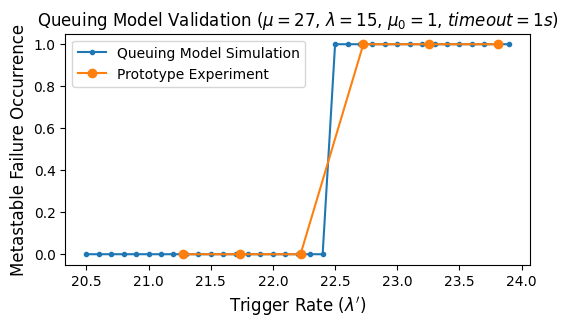

In [14]:
plot_validation(j2, trigger_values2, experiment_values2, experiment_ms2, 27, 15, 1, 1)

In [279]:
s3 = calculate_boundry_states(8, 17, 1, 1)

calculating for 0, 0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 134.218530536478/180 [00:00<00:00, 674.23it/s]/usr/local/lib/python3.10/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.33214981123285/180 [00:00<00:00, 686.26it/s]


distance is 1.5836550836550838
calculating for 0, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0112132663046/180 [00:00<00:00, 844.12it/s]


distance is 1.6661295520464068
calculating for 0, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.13198912571374/180 [00:00<00:00, 806.16it/s]


distance is 1.5881595881595882
calculating for 0, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03224855935278/180 [00:00<00:00, 718.36it/s]


distance is 1.6705314009661836
calculating for 0, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0615610011945/180 [00:00<00:00, 852.87it/s]


distance is 1.5970437017994858
calculating for 0, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.12404293006705/180 [00:00<00:00, 629.55it/s]


distance is 1.6782496782496783
calculating for 0, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0204904413255/180 [00:00<00:00, 908.24it/s]


distance is 1.6068101509797623
calculating for 0, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01649483305684/180 [00:00<00:00, 932.26it/s]


distance is 1.6883242200064323
calculating for 0, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02474349112464/180 [00:00<00:00, 717.84it/s]


distance is 1.6207117665918562
calculating for 0, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04576777117154/180 [00:00<00:00, 796.89it/s]


distance is 1.7025723472668806
calculating for 0, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00834430222937/180 [00:00<00:00, 692.82it/s]


distance is 1.6352564102564102
calculating for 0, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00867413738916/180 [00:00<00:00, 656.36it/s]


distance is 1.7180064308681668
calculating for 0, 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00808613151938/180 [00:00<00:00, 766.07it/s]


distance is 1.6557796990073648
calculating for 0, 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00295259631284/180 [00:00<00:00, 763.06it/s]


distance is 1.7409193185470908
calculating for 0, 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1119581004265/180 [00:00<00:00, 826.65it/s]


distance is 1.6847033073816908
calculating for 0, 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.10101487486816/180 [00:00<00:00, 771.13it/s]


distance is 1.771719158645209
calculating for 0, 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01581096222102/180 [00:00<00:00, 841.82it/s]


distance is 1.710309204691693
calculating for 0, 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.05320530212686/180 [00:00<00:00, 806.54it/s]


distance is 1.8157377651846243
calculating for 0, 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04446421038236/180 [00:00<00:00, 806.17it/s]


distance is 1.8066845673556957
calculating for 0, 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00378295838937/180 [00:00<00:00, 758.79it/s]


distance is 1.8907914023529047
calculating for 0, 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0248340322906/180 [00:00<00:00, 755.00it/s]


distance is 1.9916741039556896
calculating for 0, 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00912920015824/180 [00:01<00:00, 120.52it/s]


distance is 1359.3783215064366
calculating for 1, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03937351986713/180 [00:00<00:00, 727.42it/s]


distance is 1.5956805896874953
calculating for 1, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0940458508393/180 [00:00<00:00, 791.98it/s]


distance is 1.6679253661671036
calculating for 1, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0226711968422/180 [00:00<00:00, 760.59it/s]


distance is 1.5994742085321723
calculating for 1, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1460075355194/180 [00:00<00:00, 783.31it/s]


distance is 1.6711060808435942
calculating for 1, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0830593646385/180 [00:00<00:00, 748.82it/s]


distance is 1.6079161082228897
calculating for 1, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0760468045446/180 [00:00<00:00, 692.01it/s]


distance is 1.6793967215588383
calculating for 1, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0064523673575/180 [00:00<00:00, 797.77it/s]


distance is 1.6169665551569492
calculating for 1, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0393382496983/180 [00:00<00:00, 748.33it/s]


distance is 1.6890521078616365
calculating for 1, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02180927007595/180 [00:00<00:00, 797.97it/s]


distance is 1.620992675708646
calculating for 1, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01785298693687/180 [00:00<00:00, 771.06it/s]


distance is 1.7029705175003478
calculating for 1, 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.006354254404/180 [00:00<00:00, 758.50it/s]


distance is 1.6357143446577143
calculating for 1, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00039370756994/180 [00:00<00:00, 815.62it/s]


distance is 1.7180768620015934
calculating for 1, 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.27092177808797/180 [00:00<00:00, 861.24it/s]


distance is 1.6558382765332615
calculating for 1, 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04780345614225/180 [00:00<00:00, 892.11it/s]


distance is 1.7406041384613868
calculating for 1, 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.21849735959844/180 [00:00<00:00, 696.74it/s]


distance is 1.6794799751017695
calculating for 1, 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00076197996523/180 [00:00<00:00, 861.20it/s]


distance is 1.7658559491070445
calculating for 1, 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01223210420096/180 [00:00<00:00, 848.61it/s]


distance is 1.7113034457804526
calculating for 1, 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06172942306742/180 [00:00<00:00, 883.66it/s]


distance is 1.8453062228103687
calculating for 1, 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0742387371136/180 [00:00<00:00, 752.04it/s]


distance is 1.8452430280595855
calculating for 1, 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0348700093039/180 [00:00<00:00, 796.71it/s]


distance is 1.9121942600918131
calculating for 1, 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.05706184813366/180 [00:00<00:00, 750.61it/s]


distance is 1.8887741713034651
calculating for 1, 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00481969139685/180 [00:00<00:00, 300.67it/s]


distance is 1357.5399430838866
calculating for 2, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01255790146124/180 [00:00<00:00, 739.23it/s]


distance is 1.6016624758871338
calculating for 2, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06891457332046/180 [00:00<00:00, 818.22it/s]


distance is 1.6799508110291435
calculating for 2, 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.027626228018/180 [00:00<00:00, 637.82it/s]


distance is 1.6045567001212688
calculating for 2, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0462294371752/180 [00:00<00:00, 861.63it/s]


distance is 1.683448426844354
calculating for 2, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02383285584423/180 [00:00<00:00, 836.50it/s]


distance is 1.6110688251722511
calculating for 2, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00548584054692/180 [00:00<00:00, 834.34it/s]


distance is 1.6904751922912353
calculating for 2, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02974957792316/180 [00:00<00:00, 873.07it/s]


distance is 1.618552073830772
calculating for 2, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.12696602058597/180 [00:00<00:00, 576.19it/s]


distance is 1.6987313810739806
calculating for 2, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.18385288537414/180 [00:00<00:00, 777.12it/s]


distance is 1.6291387808063298
calculating for 2, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.10814314040007/180 [00:00<00:00, 681.78it/s]


distance is 1.7117102435504385
calculating for 2, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.14758400970442/180 [00:00<00:00, 613.70it/s]


distance is 1.6429505497037373
calculating for 2, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.07490513668293/180 [00:00<00:00, 568.47it/s]


distance is 1.7263479995566928
calculating for 2, 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.10450830343314/180 [00:00<00:00, 444.63it/s]


distance is 1.6627659670259634
calculating for 2, 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04991685343575/180 [00:00<00:00, 442.94it/s]


distance is 1.7482429824553725
calculating for 2, 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0386167352031/180 [00:00<00:00, 774.35it/s]


distance is 1.6974310796690553
calculating for 2, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0472339798879/180 [00:00<00:00, 892.80it/s]


distance is 1.8069309281428854
calculating for 2, 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.12141348335894/180 [00:00<00:00, 712.21it/s]


distance is 1.7726846240707297
calculating for 2, 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03098183013807/180 [00:00<00:00, 884.09it/s]


distance is 1.8463610551328
calculating for 2, 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.10163280638992/180 [00:00<00:00, 879.00it/s]


distance is 1.8657249026102185
calculating for 2, 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0005677125648/180 [00:00<00:00, 881.18it/s]


distance is 2.026461577633069
calculating for 2, 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01329200690867/180 [00:00<00:00, 297.55it/s]


distance is 1365.5293901005664
calculating for 3, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03594450608597/180 [00:00<00:00, 829.71it/s]


distance is 1.6079415557954595
calculating for 3, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0457340124002/180 [00:00<00:00, 722.27it/s]


distance is 1.682512722504528
calculating for 3, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.10999604611084/180 [00:00<00:00, 570.99it/s]


distance is 1.6109032266198182
calculating for 3, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03605743610996/180 [00:00<00:00, 684.07it/s]


distance is 1.6853247238266722
calculating for 3, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01366036350294/180 [00:00<00:00, 704.79it/s]


distance is 1.612628989113704
calculating for 3, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06885176509965/180 [00:00<00:00, 722.08it/s]


distance is 1.6912491551613178
calculating for 3, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01957178259354/180 [00:00<00:00, 489.11it/s]


distance is 1.619679113019971
calculating for 3, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1167796336313/180 [00:00<00:00, 758.60it/s]


distance is 1.699716111574608
calculating for 3, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.17364948044576/180 [00:00<00:00, 789.91it/s]


distance is 1.6300070097995152
calculating for 3, 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.097909838452/180 [00:00<00:00, 796.74it/s]


distance is 1.712490652239385
calculating for 3, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.13730397883802/180 [00:00<00:00, 805.06it/s]


distance is 1.6436542609824412
calculating for 3, 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0103009450996/180 [00:00<00:00, 819.73it/s]


distance is 1.732728158279692
calculating for 3, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0212541946197/180 [00:00<00:00, 909.41it/s]


distance is 1.6690909748518572
calculating for 3, 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01418164863048/180 [00:00<00:00, 682.87it/s]


distance is 1.7553141028366068
calculating for 3, 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00913888604694/180 [00:00<00:00, 815.23it/s]


distance is 1.72148451615429
calculating for 3, 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00538605014486/180 [00:00<00:00, 809.33it/s]


distance is 1.8093729228679025
calculating for 3, 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06912312374013/180 [00:00<00:00, 853.23it/s]


distance is 1.7770729332938675
calculating for 3, 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0033136519604/180 [00:00<00:00, 806.91it/s]


distance is 1.8507718851264927
calculating for 3, 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0065575533487/180 [00:00<00:00, 748.87it/s]


distance is 1.9874979925070526
calculating for 3, 19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.015766390358/180 [00:00<00:00, 308.26it/s]


distance is 1362.4008945118142
calculating for 4, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1310544539061/180 [00:00<00:00, 931.09it/s]


distance is 1.618872096971925
calculating for 4, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02370744062844/180 [00:00<00:00, 739.20it/s]


distance is 1.6875216730747133
calculating for 4, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01601881235703/180 [00:00<00:00, 795.36it/s]


distance is 1.6203219612462738
calculating for 4, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0124570492982/180 [00:00<00:00, 843.36it/s]


distance is 1.6898228061476344
calculating for 4, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0268879100775/180 [00:00<00:00, 792.05it/s]


distance is 1.6170419066433754
calculating for 4, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03281646188108/180 [00:00<00:00, 865.71it/s]


distance is 1.695029170702649
calculating for 4, 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.019555799566/180 [00:00<00:00, 813.27it/s]


distance is 1.623834468842644
calculating for 4, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0934407774025/180 [00:00<00:00, 818.47it/s]


distance is 1.7026654632809473
calculating for 4, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.15029387819862/180 [00:00<00:00, 708.75it/s]


distance is 1.6325378332154352
calculating for 4, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.07452325142847/180 [00:00<00:00, 869.90it/s]


distance is 1.7147056385277233
calculating for 4, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.11386610348688/180 [00:00<00:00, 844.28it/s]


distance is 1.6456070435292336
calculating for 4, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04104602668022/180 [00:00<00:00, 866.65it/s]


distance is 1.7287487695454986
calculating for 4, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0704669243555/180 [00:00<00:00, 714.92it/s]


distance is 1.664941819700999
calculating for 4, 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03810876137214/180 [00:00<00:00, 763.54it/s]


distance is 1.7776207678391083
calculating for 4, 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02264666269724/180 [00:00<00:00, 637.26it/s]


distance is 1.7410351578784706
calculating for 4, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0146001758871/180 [00:00<00:00, 665.92it/s]


distance is 1.8155581658553714
calculating for 4, 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0743142057664/180 [00:00<00:00, 712.27it/s]


distance is 1.7749719093547691
calculating for 4, 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01698910402158/180 [00:00<00:00, 277.61it/s]


distance is 1346.5658935278482
calculating for 5, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.05531593505003/180 [00:00<00:00, 738.79it/s]


distance is 1.626102397683965
calculating for 5, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0235031536862/180 [00:00<00:00, 662.98it/s]


distance is 1.6939982733552472
calculating for 5, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0250197807883/180 [00:00<00:00, 848.83it/s]


distance is 1.6265782718670136
calculating for 5, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0439431465853/180 [00:00<00:00, 900.65it/s]


distance is 1.6952768003720626
calculating for 5, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00126690573305/180 [00:00<00:00, 846.81it/s]


distance is 1.625848055592787
calculating for 5, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1484453087103/180 [00:00<00:00, 834.64it/s]


distance is 1.7000412771749642
calculating for 5, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.26235523420564/180 [00:00<00:00, 851.86it/s]


distance is 1.6310105142013667
calculating for 5, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0678571719711/180 [00:00<00:00, 947.98it/s]


distance is 1.7071379553780683
calculating for 5, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.10160705431161/180 [00:00<00:00, 941.27it/s]


distance is 1.6393762889475487
calculating for 5, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04653693208698/180 [00:00<00:00, 767.48it/s]


distance is 1.7186408180652977
calculating for 5, 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0693167964095/180 [00:00<00:00, 731.40it/s]


distance is 1.6514017196059185
calculating for 5, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00438130354718/180 [00:00<00:00, 687.54it/s]


distance is 1.7347940923325647
calculating for 5, 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00263288198036/180 [00:00<00:00, 763.17it/s]


distance is 1.670916912826554
calculating for 5, 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00005054261442/180 [00:00<00:00, 797.06it/s]


distance is 1.7814470955513173
calculating for 5, 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.08117743150586/180 [00:00<00:00, 791.62it/s]


distance is 1.7254290888584245
calculating for 5, 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.05928942289043/180 [00:00<00:00, 782.00it/s]


distance is 1.8211785827150413
calculating for 5, 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0031494434001/180 [00:00<00:00, 867.85it/s]


distance is 2.054656888053806
calculating for 5, 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02138172852025/180 [00:00<00:00, 275.90it/s]


distance is 1353.698816816624
calculating for 6, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0134889978136/180 [00:00<00:00, 896.48it/s]


distance is 1.6308782081160913
calculating for 6, 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00920943121457/180 [00:00<00:00, 1001.24it/s]


distance is 1.696491245575964
calculating for 6, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01851563346753/180 [00:00<00:00, 972.12it/s]


distance is 1.6309685641621177
calculating for 6, 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00216377143548/180 [00:00<00:00, 1032.94it/s]


distance is 1.7022223827039664
calculating for 6, 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.26510332629138/180 [00:00<00:00, 1043.01it/s]


distance is 1.6314683765645295
calculating for 6, 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.11172452448434/180 [00:00<00:00, 1000.59it/s]


distance is 1.7063744656220148
calculating for 6, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.21901330233717/180 [00:00<00:00, 927.43it/s]


distance is 1.63689297339373
calculating for 6, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03973658290406/180 [00:00<00:00, 957.58it/s]


distance is 1.712794992091408
calculating for 6, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.07577805140323/180 [00:00<00:00, 997.11it/s]


distance is 1.644235977685158
calculating for 6, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0275607564495/180 [00:00<00:00, 989.29it/s]


distance is 1.729260596693016
calculating for 6, 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00065015704504/180 [00:00<00:00, 1036.70it/s]


distance is 1.665319849461331
calculating for 6, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0390694521062/180 [00:00<00:00, 1018.86it/s]


distance is 1.750582047619421
calculating for 6, 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01871721694857/180 [00:00<00:00, 1003.17it/s]


distance is 1.6923687089598491
calculating for 6, 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02074176138927/180 [00:00<00:00, 946.86it/s]


distance is 1.7796957735837096
calculating for 6, 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0298753532779/180 [00:00<00:00, 1063.21it/s]


distance is 1.776575704774257
calculating for 6, 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03630026748544/180 [00:00<00:00, 913.05it/s]


distance is 2.0807759858539407
calculating for 6, 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03546291467543/180 [00:00<00:00, 352.44it/s]


distance is 1354.8421018065808
calculating for 7, 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01525827191156/180 [00:00<00:00, 1032.15it/s]


distance is 1.644116907675174
calculating for 7, 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.05501864438165/180 [00:00<00:00, 1052.31it/s]


distance is 1.7029723577078817
calculating for 7, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.2445617546323/180 [00:00<00:00, 1032.79it/s]


distance is 1.6440599949722592
calculating for 7, 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.09941608018548/180 [00:00<00:00, 1058.36it/s]


distance is 1.7059669415283565
calculating for 7, 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.20688281277333/180 [00:00<00:00, 1034.08it/s]


distance is 1.635435839303101
calculating for 7, 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02800346322246/180 [00:00<00:00, 1030.91it/s]


distance is 1.7104333584281268
calculating for 7, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0648252219912/180 [00:00<00:00, 804.75it/s]


distance is 1.641132268629912
calculating for 7, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02796907461007/180 [00:00<00:00, 865.58it/s]


distance is 1.7224373638567927
calculating for 7, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00330486316503/180 [00:00<00:00, 734.19it/s]


distance is 1.6579041136783064
calculating for 7, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1535938529828/180 [00:00<00:00, 673.81it/s]


distance is 1.7357779641035884
calculating for 7, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00544170682858/180 [00:00<00:00, 776.42it/s]


distance is 1.6716700785755598
calculating for 7, 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0023115160288/180 [00:00<00:00, 895.30it/s]


distance is 1.7557358261171394
calculating for 7, 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01880122416094/180 [00:00<00:00, 756.02it/s]


distance is 1.6974758684376279
calculating for 7, 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00545117597758/180 [00:00<00:00, 857.94it/s]


distance is 1.976227219606021
calculating for 7, 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0277441672788/180 [00:00<00:00, 696.79it/s]


distance is 2.0374368437810766
calculating for 7, 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0251938125322/180 [00:00<00:00, 280.61it/s]


distance is 1355.833381648188
calculating for 8, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0031916073156/180 [00:00<00:00, 881.02it/s]


distance is 1.6463513100491884
calculating for 8, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.14727087929325/180 [00:00<00:00, 897.65it/s]


distance is 1.706949173841003
calculating for 8, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.15916650218605/180 [00:00<00:00, 801.87it/s]


distance is 1.657660834384168
calculating for 8, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04271042646567/180 [00:00<00:00, 920.16it/s]


distance is 1.7161997396593118
calculating for 8, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.10839839520702/180 [00:00<00:00, 841.28it/s]


distance is 1.6490029338818841
calculating for 8, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01981705447238/180 [00:00<00:00, 773.46it/s]


distance is 1.7200407512973819
calculating for 8, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00581513335632/180 [00:00<00:00, 904.89it/s]


distance is 1.654001150361532
calculating for 8, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.15319338306756/180 [00:00<00:00, 914.57it/s]


distance is 1.730479712681862
calculating for 8, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01842875993734/180 [00:00<00:00, 855.36it/s]


distance is 1.6727815947572
calculating for 8, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0385361307951/180 [00:00<00:00, 824.91it/s]


distance is 1.7501250554687482
calculating for 8, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00610913124993/180 [00:00<00:00, 856.73it/s]


distance is 1.6848930180255115
calculating for 8, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.05476911172212/180 [00:00<00:00, 828.49it/s]


distance is 1.7675269246670111
calculating for 8, 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.11416571285778/180 [00:00<00:00, 844.32it/s]


distance is 1.8292486977513145
calculating for 8, 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.09384056444864/180 [00:00<00:00, 836.75it/s]


distance is 1.9662619851205314
calculating for 8, 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00361675824846/180 [00:00<00:00, 272.36it/s]


distance is 1346.7101741589001
calculating for 9, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.22420633273282/180 [00:00<00:00, 980.92it/s]


distance is 1.6591170761170482
calculating for 9, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.08625818409521/180 [00:00<00:00, 873.92it/s]


distance is 1.7173642536207396
calculating for 9, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.08968996333678/180 [00:00<00:00, 941.37it/s]


distance is 1.687666033604072
calculating for 9, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01170264083822/180 [00:00<00:00, 930.88it/s]


distance is 1.7259677163964806
calculating for 9, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03520652324292/180 [00:00<00:00, 941.14it/s]


distance is 1.6623340497561607
calculating for 9, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.14508036686425/180 [00:00<00:00, 852.66it/s]


distance is 1.7291720831296407
calculating for 9, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01990447431353/180 [00:00<00:00, 825.55it/s]


distance is 1.6700887823883444
calculating for 9, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03756975742564/180 [00:00<00:00, 796.11it/s]


distance is 1.7461139325987856
calculating for 9, 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.012879320702/180 [00:00<00:00, 863.52it/s]


distance is 1.6993783713670114
calculating for 9, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06265316935696/180 [00:00<00:00, 739.62it/s]


distance is 1.7614046718657947
calculating for 9, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.11086224767337/180 [00:00<00:00, 584.92it/s]


distance is 1.6962555690426457
calculating for 9, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00032444538851/180 [00:00<00:00, 726.06it/s]


distance is 1.7902902010701702
calculating for 9, 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01799644418466/180 [00:00<00:00, 694.65it/s]


distance is 1.7474556394501124
calculating for 9, 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0083816404427/180 [00:01<00:00, 169.67it/s]


distance is 1345.7138783428047
calculating for 10, 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.013959875807/180 [00:00<00:00, 361.44it/s]


distance is 1.6886833650727444
calculating for 10, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0077303990439/180 [00:00<00:00, 546.22it/s]


distance is 1.727027354880306
calculating for 10, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0312550228409/180 [00:00<00:00, 777.97it/s]


distance is 1.6629200785670852
calculating for 10, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.14118814339844/180 [00:00<00:00, 759.45it/s]


distance is 1.729313158790637
calculating for 10, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01615572072353/180 [00:00<00:00, 752.61it/s]


distance is 1.6698173638774918
calculating for 10, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0341204255033/180 [00:00<00:00, 783.38it/s]


distance is 1.7454645644713722
calculating for 10, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00997509364245/180 [00:00<00:00, 716.51it/s]


distance is 1.6983956290994695
calculating for 10, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06061998634516/180 [00:00<00:00, 617.01it/s]


distance is 1.7601133629529635
calculating for 10, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1100522906638/180 [00:00<00:00, 839.13it/s]


distance is 1.6947027160246924
calculating for 10, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00371954451208/180 [00:00<00:00, 828.93it/s]


distance is 1.775499796667257
calculating for 10, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04766641483582/180 [00:00<00:00, 660.61it/s]


distance is 1.7129896117343961
calculating for 10, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04908232052233/180 [00:00<00:00, 414.78it/s]


distance is 1.798447968788775
calculating for 10, 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.10059264333614/180 [00:00<00:00, 868.67it/s]


distance is 1.8325265281576868
calculating for 10, 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02615767170465/180 [00:00<00:00, 273.85it/s]


distance is 1356.4134010075124
calculating for 11, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04697886168077/180 [00:00<00:00, 827.71it/s]


distance is 1.7003979995854477
calculating for 11, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0052147156723/180 [00:00<00:00, 786.33it/s]


distance is 1.7279821627327292
calculating for 11, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0287393410385/180 [00:00<00:00, 617.42it/s]


distance is 1.663856714118528
calculating for 11, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.13867246888293/180 [00:00<00:00, 680.52it/s]


distance is 1.7302298305200603
calculating for 11, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01364007313364/180 [00:00<00:00, 712.07it/s]


distance is 1.6707028101008135
calculating for 11, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03160486070456/180 [00:00<00:00, 644.09it/s]


distance is 1.7463219963086534
calculating for 11, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00745974820825/180 [00:00<00:00, 745.49it/s]


distance is 1.6992142359810678
calculating for 11, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.05810515757605/180 [00:00<00:00, 807.47it/s]


distance is 1.7609017311553403
calculating for 11, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1262283697323/180 [00:00<00:00, 782.23it/s]


distance is 1.734929624283107
calculating for 11, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0013769654417/180 [00:00<00:00, 369.36it/s]


distance is 1.800446120866568
calculating for 11, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.13743178432614/180 [00:00<00:00, 478.86it/s]


distance is 1.7409683584512852
calculating for 11, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00622816703688/180 [00:00<00:00, 547.68it/s]


distance is 1.8578669976659707
calculating for 11, 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00652333570306/180 [00:00<00:00, 611.36it/s]


distance is 1.8576132357451922
calculating for 11, 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00963471551404/180 [00:01<00:00, 154.99it/s]


distance is 1356.5629118254535
calculating for 12, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02757929540593/180 [00:00<00:00, 628.14it/s]


distance is 1.7045381262201043
calculating for 12, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01520956012436/180 [00:00<00:00, 640.19it/s]


distance is 1.732819543210865
calculating for 12, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01359955099937/180 [00:00<00:00, 343.27it/s]


distance is 1.694510686658755
calculating for 12, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02352290749994/180 [00:00<00:00, 608.82it/s]


distance is 1.7469355130607191
calculating for 12, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0076636157596/180 [00:00<00:00, 468.62it/s]


distance is 1.6985179790180833
calculating for 12, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0556875776182/180 [00:00<00:00, 566.73it/s]


distance is 1.75893187121175
calculating for 12, 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.024182200941/180 [00:00<00:00, 599.62it/s]


distance is 1.7111561910379909
calculating for 12, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01742641899074/180 [00:00<00:00, 604.99it/s]


distance is 1.7806632944826146
calculating for 12, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00421159900162/180 [00:00<00:00, 529.76it/s]


distance is 1.7221146977743766
calculating for 12, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03023650650164/180 [00:00<00:00, 596.11it/s]


distance is 1.8367780470296238
calculating for 12, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.05905682362592/180 [00:00<00:00, 383.21it/s]


distance is 1.7661711413695373
calculating for 12, 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0155937159695/180 [00:00<00:00, 627.88it/s]


distance is 1.847036377560658
calculating for 12, 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0045416330377/180 [00:00<00:00, 237.41it/s]


distance is 1337.1918017192868
calculating for 13, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02688104954962/180 [00:00<00:00, 605.10it/s]


distance is 1.7151835291677018
calculating for 13, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01720659380743/180 [00:00<00:00, 707.39it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01720659380743/180 [00:00<00:00, 707.39it/s]


distance is 1.7501983405664028
calculating for 13, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0179137116327/180 [00:00<00:00, 450.28it/s]


distance is 1.706241901840207
calculating for 13, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0477456871489/180 [00:00<00:00, 526.73it/s]


distance is 1.760190382562929
calculating for 13, 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.023761280704/180 [00:00<00:00, 841.90it/s]


distance is 1.7112279728463968
calculating for 13, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01471690930083/180 [00:00<00:00, 775.59it/s]


distance is 1.7795708236225551
calculating for 13, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00395295713338/180 [00:00<00:00, 380.94it/s]


distance is 1.7210447042566528
calculating for 13, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0010052020191/180 [00:00<00:00, 356.68it/s]


distance is 1.7978195447579086
calculating for 13, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1216008064297/180 [00:00<00:00, 488.63it/s]


distance is 1.7364964241319032
calculating for 13, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0440404786214/180 [00:00<00:00, 499.05it/s]


distance is 1.8173306968121152
calculating for 13, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.08560257214188/180 [00:00<00:00, 468.78it/s]


distance is 1.8974621025469818
calculating for 13, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06342134677996/180 [00:00<00:00, 551.67it/s]


distance is 1.9712971975059
calculating for 13, 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01924262063858/180 [00:01<00:00, 145.11it/s]


distance is 1355.418855855069
calculating for 14, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.08402374819173/180 [00:00<00:00, 271.24it/s]


distance is 1.8066490776017508
calculating for 15, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.09075822050832/180 [00:00<00:00, 244.38it/s]


distance is 1.7436327348537843
calculating for 15, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0156873479192/180 [00:00<00:00, 586.15it/s]


distance is 1.8235497214764098
calculating for 15, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01195900129125/180 [00:00<00:00, 250.70it/s]


distance is 1.8011719308048157
calculating for 15, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04443619194674/180 [00:00<00:00, 551.49it/s]


distance is 1.8640233237502464
calculating for 15, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.08146656651348/180 [00:00<00:00, 480.30it/s]


distance is 1.8989879604510735
calculating for 15, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00394490824536/180 [00:01<00:00, 147.38it/s]


distance is 1347.8783487099379
calculating for 16, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02140101731945/180 [00:00<00:00, 613.18it/s]


distance is 1.7466406437656046
calculating for 16, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.09377667661124/180 [00:00<00:00, 622.47it/s]


distance is 1.8023585787178764
calculating for 16, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1393214058178/180 [00:00<00:00, 748.72it/s]


distance is 1.7341639346636069
calculating for 16, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.07354128465266/180 [00:00<00:00, 764.67it/s]


distance is 1.8080666740210523
calculating for 16, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0808561990268/180 [00:00<00:00, 754.69it/s]


distance is 1.7443118652161527
calculating for 16, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00694709991006/180 [00:00<00:00, 680.99it/s]


distance is 1.8235315394012472
calculating for 16, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00525378541022/180 [00:00<00:00, 536.64it/s]


distance is 1.8004994503640792
calculating for 16, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02250545392735/180 [00:00<00:00, 677.25it/s]


distance is 1.8836503383120515
calculating for 16, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00407669260915/180 [00:00<00:00, 744.04it/s]


distance is 1.851160962142656
calculating for 16, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.07160652329608/180 [00:00<00:00, 733.35it/s]


distance is 1.9278678303466228
calculating for 16, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.10346887443498/180 [00:00<00:00, 703.21it/s]


distance is 1.978279989497869
calculating for 16, 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00087579435584/180 [00:00<00:00, 195.59it/s]


distance is 1372.2986405370737
calculating for 17, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0027706293033/180 [00:00<00:00, 653.18it/s]


distance is 1.7678918788809412
calculating for 17, 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.069896983558/180 [00:00<00:00, 716.55it/s]


distance is 1.811603992260297
calculating for 17, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06806524295467/180 [00:00<00:00, 656.50it/s]


distance is 1.7464412050423281
calculating for 17, 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.026554993539/180 [00:00<00:00, 657.02it/s]


distance is 1.8246317115183477
calculating for 17, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00175648740824/180 [00:00<00:00, 527.73it/s]


distance is 1.7694103211296788
calculating for 17, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02137396143158/180 [00:00<00:00, 568.70it/s]


distance is 1.8416856587147552
calculating for 17, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.11515299219803/180 [00:00<00:00, 605.08it/s]


distance is 1.7915420730834932
calculating for 17, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01121032136197/180 [00:00<00:00, 531.77it/s]


distance is 1.8645100091404785
calculating for 17, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0647898889851/180 [00:00<00:00, 467.90it/s]


distance is 1.863149452814024
calculating for 17, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03296682712866/180 [00:00<00:00, 352.13it/s]


distance is 1.964731786067121
calculating for 17, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02832960589691/180 [00:00<00:00, 197.93it/s]


distance is 1334.1773388009738
calculating for 18, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00731636812873/180 [00:00<00:00, 615.34it/s]


distance is 1.7842362456919034
calculating for 18, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02277670928513/180 [00:00<00:00, 222.39it/s]


distance is 1.8284986355630413
calculating for 18, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01141217275782/180 [00:01<00:00, 139.82it/s]


distance is 1.7725455785277802
calculating for 18, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.05812492808607/180 [00:01<00:00, 169.44it/s]


distance is 1.8422901400899494
calculating for 18, 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0887250896055/180 [00:04<00:00, 41.44it/s]


distance is 1.7894660674079457
calculating for 18, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0212607682134/180 [00:00<00:00, 180.46it/s]


distance is 1.8616152073705903
calculating for 18, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03730189895722/180 [00:00<00:00, 390.83it/s]


distance is 1.8175092352436009
calculating for 18, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02509047093437/180 [00:00<00:00, 440.74it/s]


distance is 1.902380737762514
calculating for 18, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0317110045095/180 [00:00<00:00, 347.07it/s]


distance is 1.8816131023499285
calculating for 18, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03292337642557/180 [00:05<00:00, 31.38it/s]


distance is 2.036509334265701
calculating for 18, 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0797695038228/180 [00:04<00:00, 39.69it/s]


distance is 1.9872585579462931
calculating for 18, 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02031358186488/180 [00:04<00:00, 41.16it/s]


distance is 1375.4650796676733
calculating for 19, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00864862679413/180 [00:00<00:00, 245.96it/s]


distance is 1.8018405643360398
calculating for 19, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.05426298791443/180 [00:01<00:00, 144.30it/s]


distance is 1.8464389465622066
calculating for 19, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01055652023737/180 [00:03<00:00, 57.82it/s]


distance is 1.78837317596418
calculating for 19, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00186478399362/180 [00:00<00:00, 311.36it/s]


distance is 1.870167447839341
calculating for 19, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.07451830242684/180 [00:00<00:00, 284.79it/s]


distance is 1.8242963132555006
calculating for 19, 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1200297423084/180 [00:00<00:00, 437.08it/s]


distance is 1.8896233373417497
calculating for 19, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.09356659666506/180 [00:00<00:00, 501.67it/s]


distance is 1.8482365664748865
calculating for 19, 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0997010207919/180 [00:00<00:00, 396.60it/s]


distance is 1.9182162598109
calculating for 19, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0236271901762/180 [00:00<00:00, 575.43it/s]


distance is 1.8786530074475996
calculating for 19, 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0271106559614/180 [00:00<00:00, 625.40it/s]


distance is 1.9855103031676584
calculating for 19, 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04933057524215/180 [00:00<00:00, 225.38it/s]


distance is 1373.723354762305
calculating for 20, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01187255487434/180 [00:00<00:00, 747.05it/s]


distance is 1.8022936304572796
calculating for 20, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00717750923567/180 [00:00<00:00, 799.45it/s]


distance is 1.8755504941941707
calculating for 20, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.1040287480284/180 [00:00<00:00, 356.96it/s]


distance is 1.8021186173015842
calculating for 20, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0132864645993/180 [00:00<00:00, 282.56it/s]


distance is 1.8842651117661025
calculating for 20, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04647815944517/180 [00:00<00:00, 906.88it/s]


distance is 1.8362766208169938
calculating for 20, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.09199137424613/180 [00:00<00:00, 764.86it/s]


distance is 1.9012705567173576
calculating for 20, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06553280416222/180 [00:00<00:00, 888.32it/s]


distance is 1.8594077564717058
calculating for 20, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00470505309002/180 [00:00<00:00, 829.42it/s]


distance is 1.9546328135048618
calculating for 20, 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.23994384914837/180 [00:00<00:00, 724.52it/s]


distance is 1.910370250531966
calculating for 20, 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04651119678624/180 [00:00<00:00, 261.53it/s]


distance is 1372.7290652839686
calculating for 21, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.11340470788622/180 [00:00<00:00, 851.26it/s]


distance is 1.8399214958283874
calculating for 21, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01009041050938/180 [00:00<00:00, 759.32it/s]


distance is 1.8861462868260979
calculating for 21, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04331243099404/180 [00:00<00:00, 892.87it/s]


distance is 1.8378809455061553
calculating for 21, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.08891088839263/180 [00:00<00:00, 859.51it/s]


distance is 1.9026168143194893
calculating for 21, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06265534578824/180 [00:00<00:00, 685.90it/s]


distance is 1.8604835185407222
calculating for 21, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00224451699145/180 [00:00<00:00, 863.28it/s]


distance is 1.9554553174307217
calculating for 21, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.23822937230796/180 [00:00<00:00, 765.09it/s]


distance is 1.9109350343486278
calculating for 21, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02754885640672/180 [00:00<00:00, 729.34it/s]


distance is 2.0525246200002814
calculating for 21, 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0712077251378/180 [00:00<00:00, 266.88it/s]


distance is 1371.7314756470205
calculating for 22, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.07554170815675/180 [00:00<00:00, 765.42it/s]


distance is 1.8590716182834575
calculating for 22, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0868312115916/180 [00:00<00:00, 731.83it/s]


distance is 1.9074183728260348
calculating for 22, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06902235471844/180 [00:00<00:00, 776.02it/s]


distance is 1.8558914182303896
calculating for 22, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0309675847358/180 [00:00<00:00, 762.56it/s]


distance is 1.9216955269785991
calculating for 22, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0010431051764/180 [00:00<00:00, 763.40it/s]


distance is 1.878243880011263
calculating for 22, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00192599098108/180 [00:00<00:00, 648.20it/s]


distance is 1.9570108784797595
calculating for 22, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04947383620188/180 [00:00<00:00, 505.31it/s]


distance is 1.9134317758030621
calculating for 22, 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01807709774252/180 [00:01<00:00, 154.64it/s]


distance is 1366.3125914099885
calculating for 23, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01577775642363/180 [00:00<00:00, 815.27it/s]


distance is 1.8800315330664676
calculating for 23, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00100054928586/180 [00:00<00:00, 822.36it/s]


distance is 1.923605220467772
calculating for 23, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.08170374401783/180 [00:00<00:00, 709.37it/s]


distance is 1.877194500466515
calculating for 23, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00594763189167/180 [00:00<00:00, 892.78it/s]


distance is 1.956181266919474
calculating for 23, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02156591152755/180 [00:00<00:00, 987.41it/s]


distance is 1.902059104358301
calculating for 23, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.02756664643266/180 [00:00<00:00, 751.75it/s]


distance is 2.058409150107491
calculating for 23, 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01256268162106/180 [00:00<00:00, 286.78it/s]


distance is 1334.626897245951
calculating for 24, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01670950977402/180 [00:00<00:00, 967.50it/s]


distance is 1.9028564027840837
calculating for 24, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04996545379444/180 [00:00<00:00, 866.89it/s]


distance is 1.9602043982657553
calculating for 24, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01537968829817/180 [00:00<00:00, 817.95it/s]


distance is 1.904634733972172
calculating for 24, 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03101158668127/180 [00:00<00:00, 868.67it/s]


distance is 1.9869783131016223
calculating for 24, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.18248943179677/180 [00:00<00:00, 938.08it/s]


distance is 1.9344094178908862
calculating for 24, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01018555919805/180 [00:00<00:00, 981.36it/s]


distance is 2.0739390257269283
calculating for 24, 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0050656184296/180 [00:00<00:00, 327.85it/s]


distance is 1350.9026017972685
calculating for 25, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.23172499958264/180 [00:00<00:00, 994.37it/s]


distance is 1.9290359167915967
calculating for 25, 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0487031686949/180 [00:00<00:00, 994.00it/s]


distance is 1.9875285086962877
calculating for 25, 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.22575732811265/180 [00:00<00:00, 977.40it/s]


distance is 1.9255646271694926
calculating for 25, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0309865685551/180 [00:00<00:00, 949.20it/s]


distance is 2.012453568986729
calculating for 25, 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0984850329752/180 [00:00<00:00, 990.93it/s]


distance is 1.954123692877554
calculating for 25, 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01042011338444/180 [00:00<00:00, 314.26it/s]


distance is 1353.6186351300182
calculating for 26, 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0016157313705/180 [00:00<00:00, 974.57it/s]


distance is 1.9743380510445359
calculating for 26, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01369575635024/180 [00:00<00:00, 992.98it/s]


distance is 2.01540605400038
calculating for 26, 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.084969678277/180 [00:00<00:00, 951.10it/s]


distance is 1.9556405771792225
calculating for 26, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0057058780044/180 [00:00<00:00, 979.11it/s]


distance is 2.0809312367430883
calculating for 26, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.04692920071736/180 [00:00<00:00, 352.57it/s]


distance is 1354.905277701682
calculating for 27, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0659249300727/180 [00:00<00:00, 1063.87it/s]


distance is 1.969676580098121
calculating for 27, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0444556954176/180 [00:00<00:00, 1040.60it/s]


distance is 2.046330626108835
calculating for 27, 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.09539586960767/180 [00:00<00:00, 1062.20it/s]


distance is 2.0004615825325813
calculating for 27, 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.01903190156634/180 [00:00<00:00, 1001.79it/s]


distance is 2.097700019804651
calculating for 27, 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.05291757645145/180 [00:00<00:00, 344.01it/s]


distance is 1344.96282926112
calculating for 28, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.06384184539326/180 [00:00<00:00, 813.67it/s]


distance is 1.9706233412344947
calculating for 28, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00864126461084/180 [00:00<00:00, 960.97it/s]


distance is 2.0951537513317002
calculating for 28, 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0238905428583/180 [00:00<00:00, 943.19it/s]


distance is 2.0218433641601963
calculating for 28, 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.0047094563799/180 [00:00<00:00, 363.33it/s]


distance is 1333.7938718544588
calculating for 29, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.03092242445217/180 [00:00<00:00, 868.78it/s]


distance is 2.027401293118955
calculating for 29, 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00570428000532/180 [00:00<00:00, 310.98it/s]


distance is 1334.0891249092922
calculating for 30, 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180.00759010182566/180 [00:00<00:00, 297.16it/s]

distance is 1356.79681372069


In [15]:
trigger_values3 = list(np.arange(10, 14, 0.1))
j3 = []
for i in trigger_values3:
    j3.append(meta_prob(10, i, 17, 1, 1, s3))

In [16]:
experiment_values3 = [1000/91, 1000/87, 1000/83, 1000/79, 1000/75, 1000/71]
experiment_ms3 = [0, 0, 0, 0, 1, 1]

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


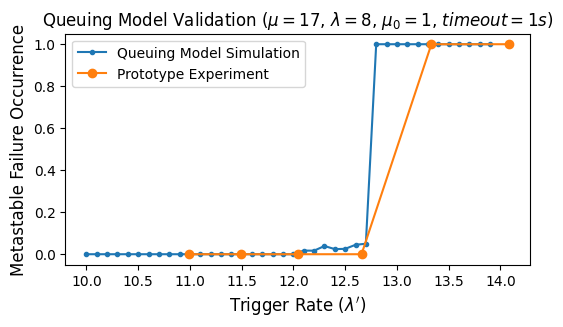

In [17]:
plot_validation(j3, trigger_values3, experiment_values3, experiment_ms3, 17, 8, 1, 1)